V1 includes:

- For IRR: calculating future IRRs based on targets

- For MOIC: adding graph of target and value of Break even (P&I based on 10% a year)

In [2]:
import os
import sys
import pandas as pd
import datetime
import numpy as np
import warnings
warnings.filterwarnings('ignore') 
#import xlsxwriter
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [3]:
import pandas_gbq
import numpy_financial as npf

## Variable for all books

In [5]:
annual_interest_rate =0.10
factor_ak_loan=0.75

## Multitude AU Oct 21

In [7]:
###Manual:
book_id='3435712288'

In [8]:
query_purchase='''SELECT book_id,actual_purchase_price,settlement_date,round(actual_purchase_price_usd,2) actual_purchase_price_usd, Region
FROM presentation.dim_books db
where 1=1
and book_id='{}' '''.format(book_id)

In [9]:
df_purch = pandas_gbq.read_gbq(query_purchase,project_id="data-team-318806")

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


In [10]:
query_cf='''SELECT book_id,book_name,month_cohort,calendary_month, calendary_year
,round(sum(actual_amount),2) actual_amount,round(sum(actual_amount_usd),2) actual_amount_usd
,round(sum(target_prediction_amount),2)target_prediction_amount  ,round(sum(target_prediction_amount_usd),2) target_prediction_amount_usd
FROM presentation.fact_performance_matrics
where 1=1
and book_id='{}'
group by all
having month_cohort is not null and actual_amount is not null
order by month_cohort'''.format(book_id)

In [11]:
df_cf=pandas_gbq.read_gbq(query_cf,project_id="data-team-318806")

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


In [12]:
book_name=df_cf.iloc[0,1]

In [13]:
### MOIC Calculation

In [14]:
cashflow=df_cf['actual_amount'].tolist()

In [15]:
#### Calculating Dynamic MOIC
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
    
df_cf['moic']=moic 

In [16]:
#### Calculating Dynamic MOIC based on target

In [17]:
cashflow=[]
cashflow=df_cf['target_prediction_amount'].tolist()

moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)

df_cf['moic_target']=moic 

In [18]:
####Adding Value of P&I

In [19]:
price= purchase_value.copy()

In [20]:
monthly_rate = ((1+annual_interest_rate )**(1/12))-1

In [21]:
monthly_payments = round(df_cf['actual_amount']*factor_ak_loan,2)

In [22]:
monthly_payments=monthly_payments.tolist()

In [23]:
remaining_balance = price
data = []

In [24]:
df_loan=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan = pd.DataFrame(data)

In [25]:
first_negative_balance = df_loan[df_loan["remaining_balance"] < 0].iloc[0]

In [26]:
first_negative_balance_cohort_month = int(first_negative_balance["cohort_month"])

In [27]:
### Getting moic_break_even when month_cohort=first_negative_balance_cohort_month
moic_break_even = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month, 'moic'].values[0]

In [28]:
####Calculting IRR

In [29]:
df_irr_actual=df_cf['actual_amount'].tolist().copy()
df_irr_target=df_cf['target_prediction_amount'].tolist().copy()

In [30]:
num_elements = len(df_irr_actual)  

combined_lists = []
combined_lists_array=[]

for i in range(1, num_elements + 1):
    new_list = df_irr_actual[:i] + df_irr_target[i:]
    combined_lists.append(new_list)

combined_lists_array = np.array(combined_lists)

In [31]:
###Adding purchase as negative number

In [32]:
fixed_value=0
fixed_value = df_purch.iloc[0, 1] * -1

extended_lists = []
extended_lists_array=[]
for lst in combined_lists_array:
    new_list = [fixed_value] + lst.tolist()
    extended_lists.append(new_list)

extended_lists_array = np.array(extended_lists)  

In [33]:
#####value of IRR

irr_temp=0
irr=[]
for list in extended_lists_array:
	irr_temp=round(npf.irr(list),4)
	irr.append(irr_temp)

df_cf['irr']=irr 

In [34]:
### IRR yearly basis
irr_yearly = [(1 + rate)**12 - 1 for rate in irr]

In [35]:
df_cf['irr_yearly']=irr_yearly 

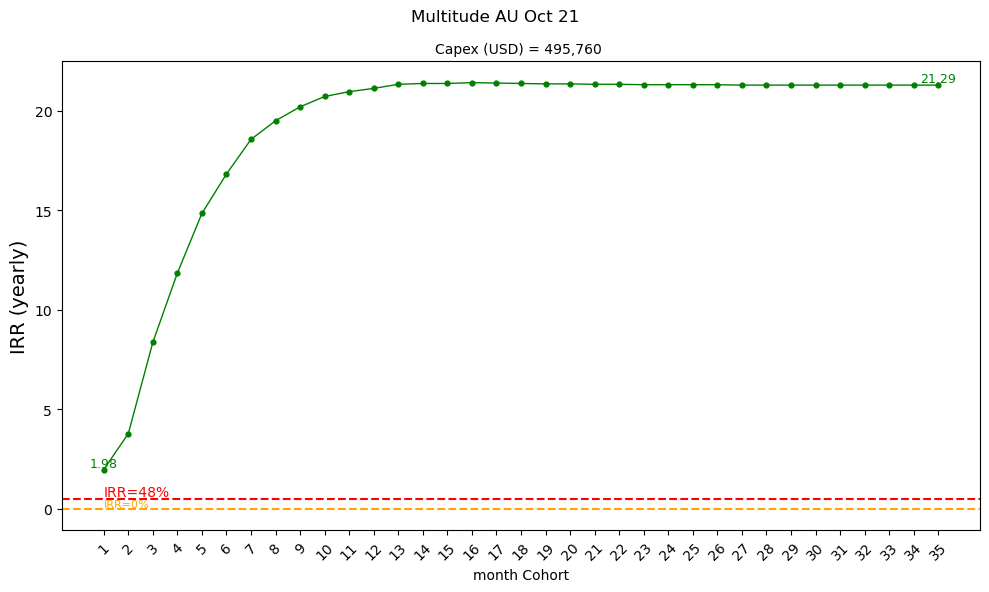

In [36]:
plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'], df_cf['irr_yearly'], color='green',s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'], df_cf['irr_yearly'], color='green', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('month Cohort')
plt.ylabel('IRR (yearly)',fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0,3]),0), fontsize=10)

# Rotate x-axis labels for better readability (optional)

#x_labels = df_cf['month_cohort'].dt.strftime('%Y-%m-%d')  # Format as string
#short_x_labels = x_labels.str.slice(0, 7)  # Get the first 6 letters

plt.xticks(df_cf['month_cohort'], rotation=45)


# Annotate each point with its y-value 
#for i, value in enumerate(df_cf['irr_yearly']):
#    plt.text(df_cf['month_cohort'][i], df_cf['irr_yearly'][i], 
#             f'{value:,.2f}', ha='center', va='bottom', fontsize=9)


#plt.axhline(y=df_average, color='red', linestyle='--', label=f'Average: {df_average:,.2f}')

#plt.text(df_cf['month_cohort'].min(), df_average, f'Avg: {df_average:,.2f}', 
 #        color='red', va='bottom', ha='right', fontsize=10)

# Get the last value for annotation
last_x = df_cf['month_cohort'].iloc[-1]
last_y = df_cf['irr_yearly'].iloc[-1]
# Add a label for the last point
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')


# Get the 1st value for annotation
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['irr_yearly'].iloc[0]
# Add a label for the last point
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Add a line where y = 0
plt.axhline(y=0, color='orange', linestyle='--', label='y = 0')
# Add a label for the y = 0 line
plt.text(df_cf['month_cohort'].min(), 0, 'IRR=0%', color='orange', va='bottom', ha='left', fontsize=8)


# Add a line where y = 3.32% (48% yearly)
plt.axhline(y=48*1E-2, color='red', linestyle='--', label='y = 3.32%')
# Add a label for the y = 0 line
plt.text(df_cf['month_cohort'].min(), 48*1E-2, 'IRR=48%', color='red', va='bottom', ha='left', fontsize=10)

# Show plot
plt.tight_layout()  
plt.show()

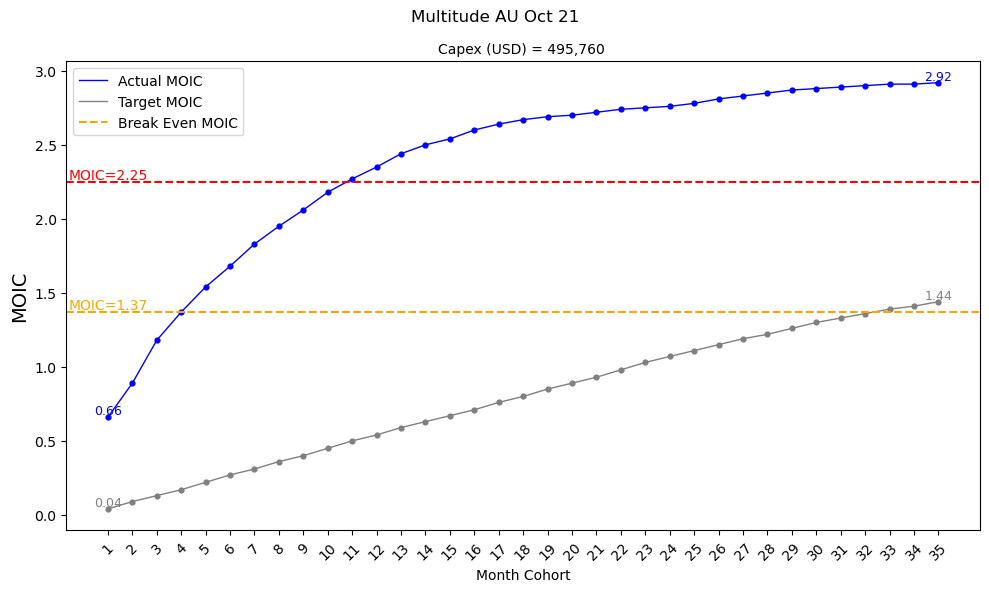

In [37]:
plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'], df_cf['moic'], color='blue', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'], df_cf['moic'], color='blue', linestyle='-', linewidth=1, label='Actual MOIC')

# Add line of moic target
plt.scatter(df_cf['month_cohort'], df_cf['moic_target'], color='gray', s=12)
plt.plot(df_cf['month_cohort'], df_cf['moic_target'], color='gray', linestyle='-', linewidth=1, label='Target MOIC')

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('MOIC', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Get current x-axis ticks
ticks = df_cf['month_cohort']
plt.xticks(ticks, rotation=45)

# Modify specific tick label to be bold or different color
#ax = plt.gca()
#for tick in ax.get_xticklabels():
#    if tick.get_text() == str(first_negative_balance_cohort_month):
#        tick.set_color('orange')  
#        tick.set_weight('bold') 



# Annotate last point with its y-value
last_x = df_cf['month_cohort'].iloc[-1]
last_y = df_cf['moic'].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')


# Annotate first point with its y-value
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['moic'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')


# Get the last value for annotation for target MOIC
last_y_target = df_cf['moic_target'].iloc[-1]
plt.text(last_x, last_y_target, f'{last_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Get the first value for annotation for target MOIC
first_y_target = df_cf['moic_target'].iloc[0]
plt.text(first_x, first_y_target, f'{first_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')



# Add a line where y = 2.25
plt.axhline(y=2.25, color='red', linestyle='--', label='_nolegend_')
plt.text(df_cf['month_cohort'].min(), 2.25, 'MOIC=2.25', color='red', va='bottom', ha='center', fontsize=10)

# Add a line where y = moic_break_even
plt.axhline(y=moic_break_even, color='orange', linestyle='--', label='Break Even MOIC')
plt.text(df_cf['month_cohort'].min(), moic_break_even, f'MOIC={moic_break_even}', color='orange', va='bottom', ha='center', fontsize=10)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()  
plt.show()

In [38]:
book_name

'Multitude AU Oct 21'

In [39]:
df_loan

,cohort_month,monthly_payment,principal_payment,interest_payment,remaining_balance
0,1,324157.69,318897.285119,5260.404881,340785.714881
1,2,116582.62,113865.146853,2717.473147,226920.568027
2,3,145306.67,143497.173524,1809.496476,83423.394503
3,4,90781.52,90116.290137,665.229863,-6692.895634
4,5,86755.04,86808.410090,-53.370090,-93501.305724
5,6,69658.49,70404.082542,-745.592542,-163905.388266
6,7,73860.56,75167.564583,-1307.004583,-239072.952849
7,8,56735.81,58642.211299,-1906.401299,-297715.164148
8,9,57488.20,59862.222527,-2374.022527,-357577.386675
9,10,55251.68,58103.052296,-2851.372296,-415680.438970


In [40]:
df_cf

,book_id,book_name,month_cohort,calendary_month,calendary_year,actual_amount,actual_amount_usd,target_prediction_amount,target_prediction_amount_usd,moic,moic_target,irr,irr_yearly
0,3435712288,Multitude AU Oct 21,1,11,2021,432210.25,325022.17,28090.08,21123.75,0.66,0.04,0.0953,1.981241
1,3435712288,Multitude AU Oct 21,2,12,2021,155443.49,110495.48,28151.71,20011.37,0.89,0.09,0.1393,3.782524
2,3435712288,Multitude AU Oct 21,3,1,2022,193742.23,140821.51,28356.57,20610.97,1.18,0.13,0.2050,8.372265
3,3435712288,Multitude AU Oct 21,4,2,2022,121042.02,86341.10,28081.37,20030.86,1.37,0.17,0.2371,11.848655
4,3435712288,Multitude AU Oct 21,5,3,2022,115673.38,83955.74,33103.12,24026.24,1.54,0.22,0.2589,14.845093
5,3435712288,Multitude AU Oct 21,6,4,2022,92877.99,69658.51,29842.31,22381.74,1.68,0.27,0.2713,16.822826
6,3435712288,Multitude AU Oct 21,7,5,2022,98480.75,69577.05,30487.67,21539.67,1.83,0.31,0.2812,18.561545
7,3435712288,Multitude AU Oct 21,8,6,2022,75647.75,54263.95,28782.74,20646.55,1.95,0.36,0.2862,19.497555
8,3435712288,Multitude AU Oct 21,9,7,2022,76650.94,52237.60,31442.08,21427.77,2.06,0.40,0.2898,20.196711
9,3435712288,Multitude AU Oct 21,10,8,2022,73668.91,51742.11,31516.81,22136.15,2.18,0.45,0.2924,20.715178


## Primagas ES Jan 2023

In [42]:
###Manual:
book_id='3791494045'

In [43]:
query_purchase='''SELECT book_id,actual_purchase_price,settlement_date,round(actual_purchase_price_usd,2) actual_purchase_price_usd, Region
FROM presentation.dim_books db
where 1=1
and book_id='{}' '''.format(book_id)
df_purch = pandas_gbq.read_gbq(query_purchase,project_id="data-team-318806")
query_cf='''SELECT book_id,book_name,month_cohort,calendary_month, calendary_year
,round(sum(actual_amount),2) actual_amount,round(sum(actual_amount_usd),2) actual_amount_usd
,round(sum(target_prediction_amount),2)target_prediction_amount  ,round(sum(target_prediction_amount_usd),2) target_prediction_amount_usd
FROM presentation.fact_performance_matrics
where 1=1
and book_id='{}'
group by all
having month_cohort is not null and actual_amount is not null
order by month_cohort'''.format(book_id)
df_cf=pandas_gbq.read_gbq(query_cf,project_id="data-team-318806")
book_name=df_cf.iloc[0,1]
### MOIC Calculation
cashflow=df_cf['actual_amount'].tolist()
#### Calculating Dynamic MOIC
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
    
df_cf['moic']=moic 
#### Calculating Dynamic MOIC based on target
cashflow=[]
cashflow=df_cf['target_prediction_amount'].tolist()

moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)

df_cf['moic_target']=moic 
####Adding Value of P&I
price= purchase_value.copy()
monthly_rate = ((1+annual_interest_rate )**(1/12))-1
monthly_payments = round(df_cf['actual_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []
df_loan=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan = pd.DataFrame(data)

first_negative_balance = df_loan[df_loan["remaining_balance"] < 0].iloc[0]
first_negative_balance_cohort_month = int(first_negative_balance["cohort_month"])


### Getting moic_break_even when month_cohort=first_negative_balance_cohort_month
moic_break_even = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month, 'moic'].values[0]

####Calculting IRR
df_irr_actual=df_cf['actual_amount'].tolist().copy()
df_irr_target=df_cf['target_prediction_amount'].tolist().copy()

num_elements = len(df_irr_actual)  

combined_lists = []
combined_lists_array=[]

for i in range(1, num_elements + 1):
    new_list = df_irr_actual[:i] + df_irr_target[i:]
    combined_lists.append(new_list)

combined_lists_array = np.array(combined_lists)

###Adding purchase as negative number

fixed_value=0
fixed_value = df_purch.iloc[0, 1] * -1

extended_lists = []
extended_lists_array=[]
for lst in combined_lists_array:
    new_list = [fixed_value] + lst.tolist()
    extended_lists.append(new_list)

extended_lists_array = np.array(extended_lists)

#####value of IRR

irr_temp=0
irr=[]
for list in extended_lists_array:
	irr_temp=round(npf.irr(list),4)
	irr.append(irr_temp)

df_cf['irr']=irr

### IRR yearly basis
irr_yearly = [(1 + rate)**12 - 1 for rate in irr]

df_cf['irr_yearly']=irr_yearly 

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


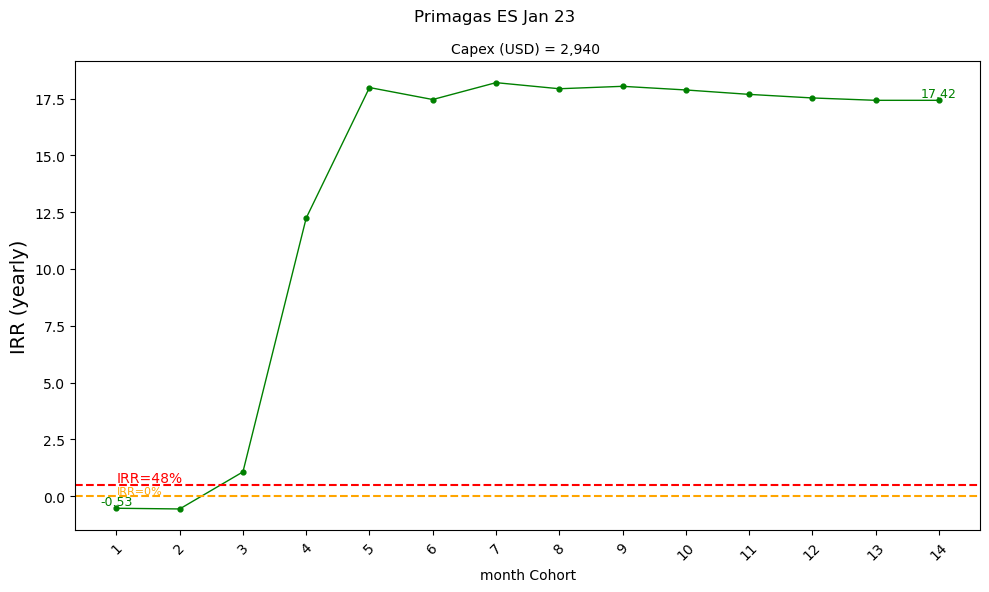

In [44]:
plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'], df_cf['irr_yearly'], color='green',s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'], df_cf['irr_yearly'], color='green', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('month Cohort')
plt.ylabel('IRR (yearly)',fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0,3]),0), fontsize=10)

# Rotate x-axis labels for better readability (optional)

#x_labels = df_cf['month_cohort'].dt.strftime('%Y-%m-%d')  # Format as string
#short_x_labels = x_labels.str.slice(0, 7)  # Get the first 6 letters

plt.xticks(df_cf['month_cohort'], rotation=45)


# Annotate each point with its y-value 
#for i, value in enumerate(df_cf['irr_yearly']):
#    plt.text(df_cf['month_cohort'][i], df_cf['irr_yearly'][i], 
#             f'{value:,.2f}', ha='center', va='bottom', fontsize=9)


#plt.axhline(y=df_average, color='red', linestyle='--', label=f'Average: {df_average:,.2f}')

#plt.text(df_cf['month_cohort'].min(), df_average, f'Avg: {df_average:,.2f}', 
 #        color='red', va='bottom', ha='right', fontsize=10)

# Get the last value for annotation
last_x = df_cf['month_cohort'].iloc[-1]
last_y = df_cf['irr_yearly'].iloc[-1]
# Add a label for the last point
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Get the 1st value for annotation
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['irr_yearly'].iloc[0]
# Add a label for the last point
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Add a line where y = 0
plt.axhline(y=0, color='orange', linestyle='--', label='y = 0')
# Add a label for the y = 0 line
plt.text(df_cf['month_cohort'].min(), 0, 'IRR=0%', color='orange', va='bottom', ha='left', fontsize=8)


# Add a line where y = 3.32% (48% yearly)
plt.axhline(y=48*1E-2, color='red', linestyle='--', label='y = 3.32%')
# Add a label for the y = 0 line
plt.text(df_cf['month_cohort'].min(), 48*1E-2, 'IRR=48%', color='red', va='bottom', ha='left', fontsize=10)

# Show plot
plt.tight_layout()  
plt.show()

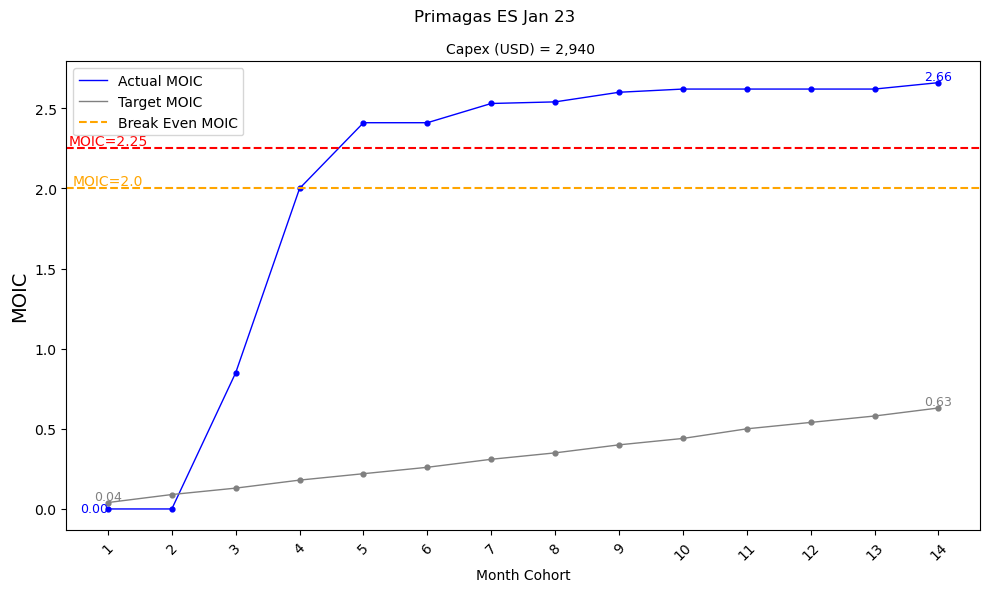

In [45]:
plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'], df_cf['moic'], color='blue', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'], df_cf['moic'], color='blue', linestyle='-', linewidth=1, label='Actual MOIC')

# Add line of moic target
plt.scatter(df_cf['month_cohort'], df_cf['moic_target'], color='gray', s=12)
plt.plot(df_cf['month_cohort'], df_cf['moic_target'], color='gray', linestyle='-', linewidth=1, label='Target MOIC')

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('MOIC', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Get current x-axis ticks
ticks = df_cf['month_cohort']
plt.xticks(ticks, rotation=45)

# Modify specific tick label to be bold or different color
#ax = plt.gca()
#for tick in ax.get_xticklabels():
#    if tick.get_text() == str(first_negative_balance_cohort_month):
#        tick.set_color('orange')  
#        tick.set_weight('bold') 



# Annotate last point with its y-value
last_x = df_cf['month_cohort'].iloc[-1]
last_y = df_cf['moic'].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate first point with its y-value
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['moic'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='right', va='center', fontsize=9, color='blue')

# Get the last value for annotation for target MOIC
last_y_target = df_cf['moic_target'].iloc[-1]
plt.text(last_x, last_y_target, f'{last_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Get the first value for annotation for target MOIC
first_y_target = df_cf['moic_target'].iloc[0]
plt.text(first_x, first_y_target, f'{first_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Add a line where y = 2.25
plt.axhline(y=2.25, color='red', linestyle='--', label='_nolegend_')
plt.text(df_cf['month_cohort'].min(), 2.25, 'MOIC=2.25', color='red', va='bottom', ha='center', fontsize=10)

# Add a line where y = moic_break_even
plt.axhline(y=moic_break_even, color='orange', linestyle='--', label='Break Even MOIC')
plt.text(df_cf['month_cohort'].min(), moic_break_even, f'MOIC={moic_break_even}', color='orange', va='bottom', ha='center', fontsize=10)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()  
plt.show()

In [46]:
book_name

'Primagas ES Jan 23'

In [47]:
df_loan

,cohort_month,monthly_payment,principal_payment,interest_payment,remaining_balance
0,1,0.00,-21.482653,21.482653,2715.522653
1,2,0.00,-21.653959,21.653959,2737.176612
2,3,1715.78,1693.953369,21.826631,1043.223243
3,4,2320.74,2312.421191,8.318809,-1269.197948
4,5,829.11,839.230763,-10.120763,-2108.428711
5,6,0.00,16.812907,-16.812907,-2125.241618
6,7,239.17,256.116975,-16.946975,-2381.358593
7,8,28.66,47.649288,-18.989288,-2429.007881
8,9,126.68,146.049250,-19.369250,-2575.057131
9,10,28.66,49.193867,-20.533867,-2624.250998


In [48]:
df_cf

,book_id,book_name,month_cohort,calendary_month,calendary_year,actual_amount,actual_amount_usd,target_prediction_amount,target_prediction_amount_usd,moic,moic_target,irr,irr_yearly
0,3791494045,Primagas ES Jan 23,1,8,2023,0.00,0.00,110.69,121.84,0.00,0.04,-0.0611,-0.530720
1,3791494045,Primagas ES Jan 23,2,9,2023,0.00,0.00,120.69,130.29,0.00,0.09,-0.0664,-0.561540
2,3791494045,Primagas ES Jan 23,3,10,2023,2287.71,2416.64,121.74,128.60,0.85,0.13,0.0625,1.069890
3,3791494045,Primagas ES Jan 23,4,11,2023,3094.32,3275.30,120.95,128.02,2.00,0.18,0.2402,12.240388
4,3791494045,Primagas ES Jan 23,5,12,2023,1105.48,1204.16,114.65,124.89,2.41,0.22,0.2780,17.983236
5,3791494045,Primagas ES Jan 23,6,1,2024,0.00,0.00,108.32,119.56,2.41,0.26,0.2750,17.455347
6,3791494045,Primagas ES Jan 23,7,2,2024,318.89,346.77,127.29,138.42,2.53,0.31,0.2792,18.198240
7,3791494045,Primagas ES Jan 23,8,3,2024,38.22,41.47,123.92,134.46,2.54,0.35,0.2777,17.929831
8,3791494045,Primagas ES Jan 23,9,4,2024,168.90,182.26,122.10,131.76,2.60,0.40,0.2783,18.036779
9,3791494045,Primagas ES Jan 23,10,5,2024,38.22,40.73,127.89,136.28,2.62,0.44,0.2774,17.876564


## Pagantis ES Sep 2023

In [50]:
###Manual:
book_id='5176948179'

In [51]:

query_purchase='''SELECT book_id,actual_purchase_price,settlement_date,round(actual_purchase_price_usd,2) actual_purchase_price_usd, Region
FROM presentation.dim_books db
where 1=1
and book_id='{}' '''.format(book_id)
df_purch = pandas_gbq.read_gbq(query_purchase,project_id="data-team-318806")
query_cf='''SELECT book_id,book_name,month_cohort,calendary_month, calendary_year
,round(sum(actual_amount),2) actual_amount,round(sum(actual_amount_usd),2) actual_amount_usd
,round(sum(target_prediction_amount),2)target_prediction_amount  ,round(sum(target_prediction_amount_usd),2) target_prediction_amount_usd
FROM presentation.fact_performance_matrics
where 1=1
and book_id='{}'
group by all
having month_cohort is not null and actual_amount is not null
order by month_cohort'''.format(book_id)
df_cf=pandas_gbq.read_gbq(query_cf,project_id="data-team-318806")
book_name=df_cf.iloc[0,1]
### MOIC Calculation
cashflow=df_cf['actual_amount'].tolist()
#### Calculating Dynamic MOIC
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
    
df_cf['moic']=moic 
#### Calculating Dynamic MOIC based on target
cashflow=[]
cashflow=df_cf['target_prediction_amount'].tolist()

moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)

df_cf['moic_target']=moic 
####Adding Value of P&I
price= purchase_value.copy()
monthly_rate = ((1+annual_interest_rate )**(1/12))-1
monthly_payments = round(df_cf['actual_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []
df_loan=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan = pd.DataFrame(data)

first_negative_balance = df_loan[df_loan["remaining_balance"] < 0].iloc[0]
first_negative_balance_cohort_month = int(first_negative_balance["cohort_month"])


### Getting moic_break_even when month_cohort=first_negative_balance_cohort_month
moic_break_even = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month, 'moic'].values[0]

####Calculting IRR
df_irr_actual=df_cf['actual_amount'].tolist().copy()
df_irr_target=df_cf['target_prediction_amount'].tolist().copy()

num_elements = len(df_irr_actual)  

combined_lists = []
combined_lists_array=[]

for i in range(1, num_elements + 1):
    new_list = df_irr_actual[:i] + df_irr_target[i:]
    combined_lists.append(new_list)

combined_lists_array = np.array(combined_lists)

###Adding purchase as negative number

fixed_value=0
fixed_value = df_purch.iloc[0, 1] * -1

extended_lists = []
extended_lists_array=[]
for lst in combined_lists_array:
    new_list = [fixed_value] + lst.tolist()
    extended_lists.append(new_list)

extended_lists_array = np.array(extended_lists)

#####value of IRR

irr_temp=0
irr=[]
for list in extended_lists_array:
	irr_temp=round(npf.irr(list),4)
	irr.append(irr_temp)

df_cf['irr']=irr

### IRR yearly basis
irr_yearly = [(1 + rate)**12 - 1 for rate in irr]

df_cf['irr_yearly']=irr_yearly 

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


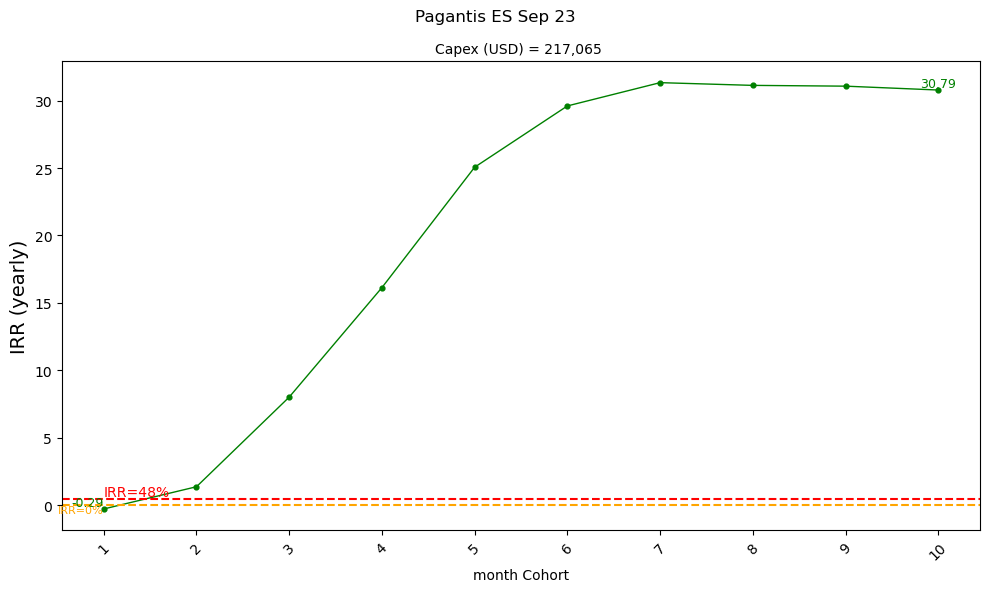

In [52]:
plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'], df_cf['irr_yearly'], color='green',s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'], df_cf['irr_yearly'], color='green', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('month Cohort')
plt.ylabel('IRR (yearly)',fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0,3]),0), fontsize=10)

# Rotate x-axis labels for better readability (optional)

#x_labels = df_cf['month_cohort'].dt.strftime('%Y-%m-%d')  # Format as string
#short_x_labels = x_labels.str.slice(0, 7)  # Get the first 6 letters

plt.xticks(df_cf['month_cohort'], rotation=45)


# Annotate each point with its y-value 
#for i, value in enumerate(df_cf['irr_yearly']):
#    plt.text(df_cf['month_cohort'][i], df_cf['irr_yearly'][i], 
#             f'{value:,.2f}', ha='center', va='bottom', fontsize=9)


#plt.axhline(y=df_average, color='red', linestyle='--', label=f'Average: {df_average:,.2f}')

#plt.text(df_cf['month_cohort'].min(), df_average, f'Avg: {df_average:,.2f}', 
 #        color='red', va='bottom', ha='right', fontsize=10)

# Get the last value for annotation
last_x = df_cf['month_cohort'].iloc[-1]
last_y = df_cf['irr_yearly'].iloc[-1]
# Add a label for the last point
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Get the 1st value for annotation
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['irr_yearly'].iloc[0]
# Add a label for the last point
plt.text(first_x, first_y, f'{first_y:.2f}', ha='right', va='bottom', fontsize=9, color='green')

# Add a line where y = 0
plt.axhline(y=0, color='orange', linestyle='--', label='y = 0')
# Add a label for the y = 0 line
plt.text(df_cf['month_cohort'].min(), 0, 'IRR=0%', color='orange', va='top', ha='right', fontsize=8)


# Add a line where y = 3.32% (48% yearly)
plt.axhline(y=48*1E-2, color='red', linestyle='--', label='y = 3.32%')
# Add a label for the y = 0 line
plt.text(df_cf['month_cohort'].min(), 48*1E-2, 'IRR=48%', color='red', va='bottom', ha='left', fontsize=10)

# Show plot
plt.tight_layout()  
plt.show()

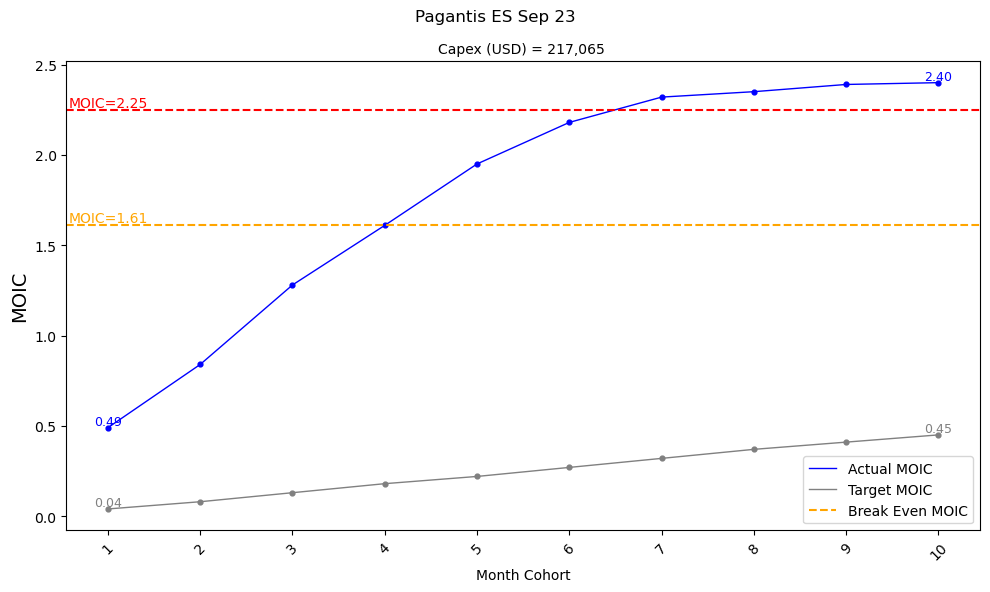

In [53]:
plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'], df_cf['moic'], color='blue', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'], df_cf['moic'], color='blue', linestyle='-', linewidth=1, label='Actual MOIC')

# Add line of moic target
plt.scatter(df_cf['month_cohort'], df_cf['moic_target'], color='gray', s=12)
plt.plot(df_cf['month_cohort'], df_cf['moic_target'], color='gray', linestyle='-', linewidth=1, label='Target MOIC')

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('MOIC', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Get current x-axis ticks
ticks = df_cf['month_cohort']
plt.xticks(ticks, rotation=45)

# Modify specific tick label to be bold or different color
#ax = plt.gca()
#for tick in ax.get_xticklabels():
#    if tick.get_text() == str(first_negative_balance_cohort_month):
#        tick.set_color('orange')  
#        tick.set_weight('bold') 



# Annotate last point with its y-value
last_x = df_cf['month_cohort'].iloc[-1]
last_y = df_cf['moic'].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')


# Annotate first point with its y-value
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['moic'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Get the last value for annotation for target MOIC
last_y_target = df_cf['moic_target'].iloc[-1]
plt.text(last_x, last_y_target, f'{last_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Get the first value for annotation for target MOIC
first_y_target = df_cf['moic_target'].iloc[0]
plt.text(first_x, first_y_target, f'{first_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Add a line where y = 2.25
plt.axhline(y=2.25, color='red', linestyle='--', label='_nolegend_')
plt.text(df_cf['month_cohort'].min(), 2.25, 'MOIC=2.25', color='red', va='bottom', ha='center', fontsize=10)

# Add a line where y = moic_break_even
plt.axhline(y=moic_break_even, color='orange', linestyle='--', label='Break Even MOIC')
plt.text(df_cf['month_cohort'].min(), moic_break_even, f'MOIC={moic_break_even}', color='orange', va='bottom', ha='center', fontsize=10)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()  
plt.show()

In [54]:
book_name

'Pagantis ES Sep 23'

In [55]:
df_loan

,cohort_month,monthly_payment,principal_payment,interest_payment,remaining_balance
0,1,74092.31,72497.481914,1594.828086,127502.518086
1,2,52402.46,51385.737016,1016.722984,76116.781070
2,3,64947.83,64340.864099,606.965901,11775.916971
3,4,49639.77,49545.867184,93.902816,-37769.950213
4,5,51653.01,51954.192887,-301.182887,-89724.143100
5,6,33775.44,34490.912917,-715.472917,-124215.056017
6,7,20765.95,21756.458300,-990.508300,-145971.514317
7,8,5352.75,6516.747354,-1163.997354,-152488.261671
8,9,5454.44,6670.402812,-1215.962812,-159158.664483
9,10,1476.94,2746.093541,-1269.153541,-161904.758024


In [56]:
df_cf

,book_id,book_name,month_cohort,calendary_month,calendary_year,actual_amount,actual_amount_usd,target_prediction_amount,target_prediction_amount_usd,moic,moic_target,irr,irr_yearly
0,5176948179,Pagantis ES Sep 23,1,12,2023,98789.75,107608.25,8511.70,9271.50,0.49,0.04,-0.0285,-0.293172
1,5176948179,Pagantis ES Sep 23,2,1,2024,69869.94,77120.25,8041.18,8875.60,0.84,0.08,0.0740,1.355328
2,5176948179,Pagantis ES Sep 23,3,2,2024,86597.11,94168.75,9450.00,10276.26,1.28,0.13,0.2010,8.005671
3,5176948179,Pagantis ES Sep 23,4,3,2024,66186.36,71816.49,9199.65,9982.22,1.61,0.18,0.2671,16.128948
4,5176948179,Pagantis ES Sep 23,5,4,2024,68870.68,74318.61,9064.70,9781.76,1.95,0.22,0.3122,25.061560
5,5176948179,Pagantis ES Sep 23,6,5,2024,45033.92,47988.83,9494.51,10117.50,2.18,0.27,0.3299,29.607498
6,5176948179,Pagantis ES Sep 23,7,6,2024,27687.93,30059.50,10077.80,10941.00,2.32,0.32,0.3360,31.335345
7,5176948179,Pagantis ES Sep 23,8,7,2024,7137.00,7676.59,9851.30,10596.10,2.35,0.37,0.3353,31.132624
8,5176948179,Pagantis ES Sep 23,9,8,2024,7272.59,7879.34,8217.32,8902.88,2.39,0.41,0.3351,31.074918
9,5176948179,Pagantis ES Sep 23,10,9,2024,1969.25,2178.12,8959.87,9910.22,2.40,0.45,0.3341,30.787810


## IPF AU Sep 2023

In [58]:
###Manual:
book_id='5152696966'

In [59]:
query_purchase='''SELECT book_id,actual_purchase_price,settlement_date,round(actual_purchase_price_usd,2) actual_purchase_price_usd, Region
FROM presentation.dim_books db
where 1=1
and book_id='{}' '''.format(book_id)
df_purch = pandas_gbq.read_gbq(query_purchase,project_id="data-team-318806")
query_cf='''SELECT book_id,book_name,month_cohort,calendary_month, calendary_year
,round(sum(actual_amount),2) actual_amount,round(sum(actual_amount_usd),2) actual_amount_usd
,round(sum(target_prediction_amount),2)target_prediction_amount  ,round(sum(target_prediction_amount_usd),2) target_prediction_amount_usd
FROM presentation.fact_performance_matrics
where 1=1
and book_id='{}'
group by all
having month_cohort is not null and actual_amount is not null
order by month_cohort'''.format(book_id)
df_cf=pandas_gbq.read_gbq(query_cf,project_id="data-team-318806")
book_name=df_cf.iloc[0,1]
### MOIC Calculation
cashflow=df_cf['actual_amount'].tolist()
#### Calculating Dynamic MOIC
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
    
df_cf['moic']=moic 
#### Calculating Dynamic MOIC based on target
cashflow=[]
cashflow=df_cf['target_prediction_amount'].tolist()

moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)

df_cf['moic_target']=moic 
####Adding Value of P&I
price= purchase_value.copy()
monthly_rate = ((1+annual_interest_rate )**(1/12))-1
monthly_payments = round(df_cf['actual_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []
df_loan=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan = pd.DataFrame(data)

first_negative_balance = df_loan[df_loan["remaining_balance"] < 0].iloc[0]
first_negative_balance_cohort_month = int(first_negative_balance["cohort_month"])


### Getting moic_break_even when month_cohort=first_negative_balance_cohort_month
moic_break_even = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month, 'moic'].values[0]

####Calculting IRR
df_irr_actual=df_cf['actual_amount'].tolist().copy()
df_irr_target=df_cf['target_prediction_amount'].tolist().copy()

num_elements = len(df_irr_actual)  

combined_lists = []
combined_lists_array=[]

for i in range(1, num_elements + 1):
    new_list = df_irr_actual[:i] + df_irr_target[i:]
    combined_lists.append(new_list)

combined_lists_array = np.array(combined_lists)

###Adding purchase as negative number

fixed_value=0
fixed_value = df_purch.iloc[0, 1] * -1

extended_lists = []
extended_lists_array=[]
for lst in combined_lists_array:
    new_list = [fixed_value] + lst.tolist()
    extended_lists.append(new_list)

extended_lists_array = np.array(extended_lists)

#####value of IRR

irr_temp=0
irr=[]
for list in extended_lists_array:
	irr_temp=round(npf.irr(list),4)
	irr.append(irr_temp)

df_cf['irr']=irr

### IRR yearly basis
irr_yearly = [(1 + rate)**12 - 1 for rate in irr]

df_cf['irr_yearly']=irr_yearly 

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


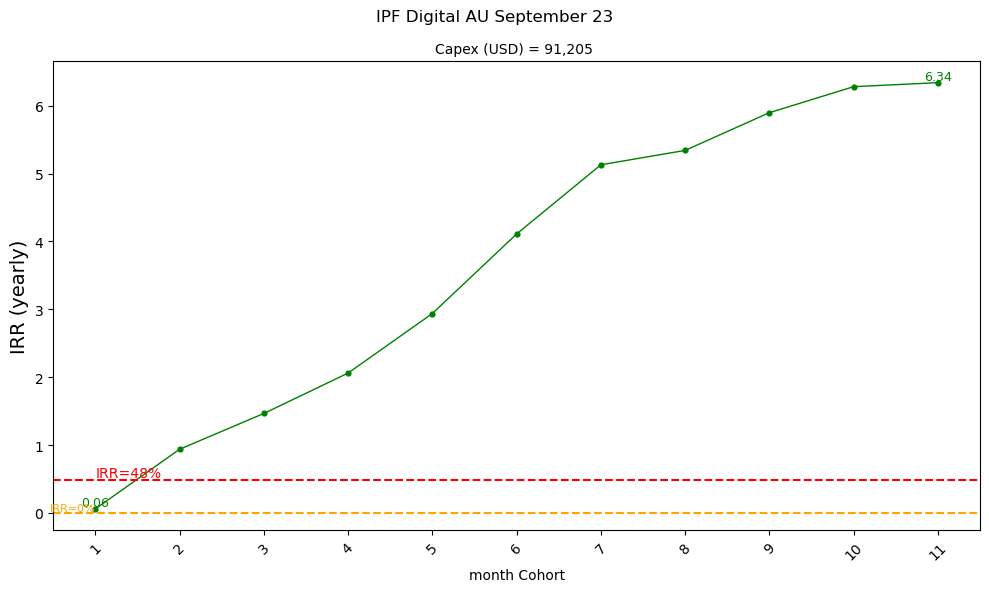

In [60]:

plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'], df_cf['irr_yearly'], color='green',s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'], df_cf['irr_yearly'], color='green', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('month Cohort')
plt.ylabel('IRR (yearly)',fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0,3]),0), fontsize=10)

# Rotate x-axis labels for better readability (optional)

#x_labels = df_cf['month_cohort'].dt.strftime('%Y-%m-%d')  # Format as string
#short_x_labels = x_labels.str.slice(0, 7)  # Get the first 6 letters

plt.xticks(df_cf['month_cohort'], rotation=45)


# Annotate each point with its y-value 
#for i, value in enumerate(df_cf['irr_yearly']):
#    plt.text(df_cf['month_cohort'][i], df_cf['irr_yearly'][i], 
#             f'{value:,.2f}', ha='center', va='bottom', fontsize=9)


#plt.axhline(y=df_average, color='red', linestyle='--', label=f'Average: {df_average:,.2f}')

#plt.text(df_cf['month_cohort'].min(), df_average, f'Avg: {df_average:,.2f}', 
 #        color='red', va='bottom', ha='right', fontsize=10)

# Get the last value for annotation
last_x = df_cf['month_cohort'].iloc[-1]
last_y = df_cf['irr_yearly'].iloc[-1]
# Add a label for the last point
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Get the 1st value for annotation
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['irr_yearly'].iloc[0]
# Add a label for the last point
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Add a line where y = 0
plt.axhline(y=0, color='orange', linestyle='--', label='y = 0')
# Add a label for the y = 0 line
plt.text(df_cf['month_cohort'].min(), 0, 'IRR=0%', color='orange', va='bottom', ha='right', fontsize=8)


# Add a line where y = 3.32% (48% yearly)
plt.axhline(y=48*1E-2, color='red', linestyle='--', label='y = 3.32%')
# Add a label for the y = 0 line
plt.text(df_cf['month_cohort'].min(), 48*1E-2, 'IRR=48%', color='red', va='bottom', ha='left', fontsize=10)

# Show plot
plt.tight_layout()  
plt.show()

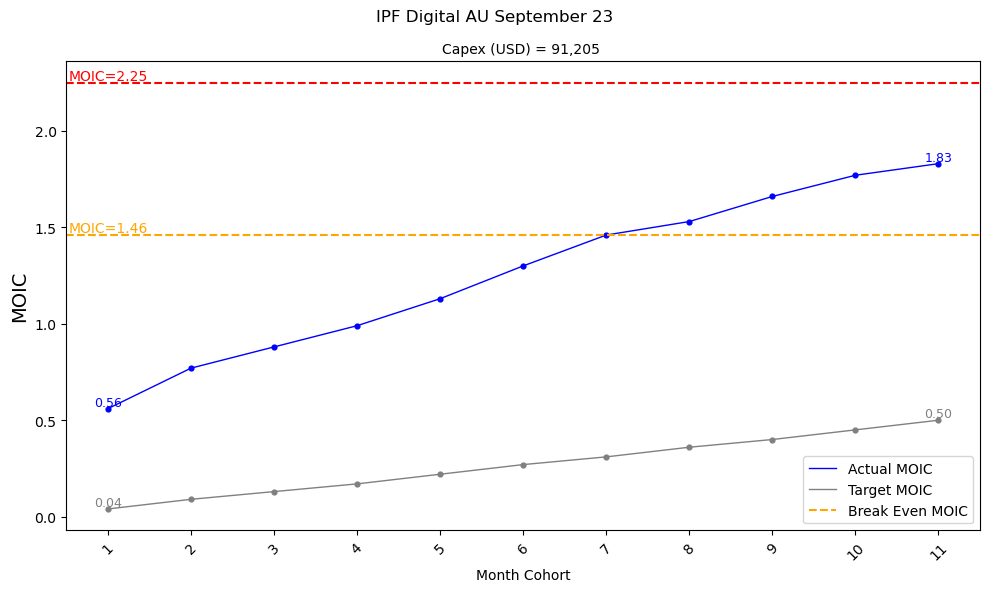

In [61]:

plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'], df_cf['moic'], color='blue', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'], df_cf['moic'], color='blue', linestyle='-', linewidth=1, label='Actual MOIC')

# Add line of moic target
plt.scatter(df_cf['month_cohort'], df_cf['moic_target'], color='gray', s=12)
plt.plot(df_cf['month_cohort'], df_cf['moic_target'], color='gray', linestyle='-', linewidth=1, label='Target MOIC')

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('MOIC', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Get current x-axis ticks
ticks = df_cf['month_cohort']
plt.xticks(ticks, rotation=45)

# Modify specific tick label to be bold or different color
#ax = plt.gca()
#for tick in ax.get_xticklabels():
#    if tick.get_text() == str(first_negative_balance_cohort_month):
#        tick.set_color('orange')  
#        tick.set_weight('bold') 



# Annotate last point with its y-value
last_x = df_cf['month_cohort'].iloc[-1]
last_y = df_cf['moic'].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')


# Annotate first point with its y-value
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['moic'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Get the last value for annotation for target MOIC
last_y_target = df_cf['moic_target'].iloc[-1]
plt.text(last_x, last_y_target, f'{last_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Get the first value for annotation for target MOIC
first_y_target = df_cf['moic_target'].iloc[0]
plt.text(first_x, first_y_target, f'{first_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Add a line where y = 2.25
plt.axhline(y=2.25, color='red', linestyle='--', label='_nolegend_')
plt.text(df_cf['month_cohort'].min(), 2.25, 'MOIC=2.25', color='red', va='bottom', ha='center', fontsize=10)

# Add a line where y = moic_break_even
plt.axhline(y=moic_break_even, color='orange', linestyle='--', label='Break Even MOIC')
plt.text(df_cf['month_cohort'].min(), moic_break_even, f'MOIC={moic_break_even}', color='orange', va='bottom', ha='center', fontsize=10)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()  
plt.show()

In [62]:
book_name

'IPF Digital AU September 23'

In [63]:
df_loan

,cohort_month,monthly_payment,principal_payment,interest_payment,remaining_balance
0,1,60402.96,59255.459503,1147.500497,84647.260497
1,2,22519.47,21844.480858,674.989142,62802.779640
2,3,11840.24,11339.441816,500.798184,51463.337824
3,4,11797.18,11386.804117,410.375883,40076.533706
4,5,15392.38,15072.804092,319.575908,25003.729614
5,6,18090.31,17890.926749,199.383251,7112.802865
6,7,17276.31,17219.591511,56.718489,-10106.788646
7,8,7530.32,7610.912952,-80.592952,-17717.701598
8,9,14073.28,14214.563441,-141.283441,-31932.265038
9,10,12392.69,12647.322366,-254.632366,-44579.587404


In [64]:
df_cf

,book_id,book_name,month_cohort,calendary_month,calendary_year,actual_amount,actual_amount_usd,target_prediction_amount,target_prediction_amount_usd,moic,moic_target,irr,irr_yearly
0,5152696966,IPF Digital AU September 23,1,11,2023,80537.28,51710.16,6127.55,3934.28,0.56,0.04,0.0048,0.059145
1,5152696966,IPF Digital AU September 23,2,12,2023,30025.96,20018.31,6140.99,4094.20,0.77,0.09,0.0567,0.938298
2,5152696966,IPF Digital AU September 23,3,1,2024,15786.99,10750.93,6185.68,4212.44,0.88,0.13,0.0781,1.465520
3,5152696966,IPF Digital AU September 23,4,2,2024,15729.58,10341.88,6125.65,4027.49,0.99,0.17,0.0977,2.060582
4,5152696966,IPF Digital AU September 23,5,3,2024,20523.17,13411.65,7221.09,4718.89,1.13,0.22,0.1210,2.937924
5,5152696966,IPF Digital AU September 23,6,4,2024,24120.41,15744.72,6509.78,4249.29,1.30,0.27,0.1456,4.109708
6,5152696966,IPF Digital AU September 23,7,5,2024,23035.08,14898.05,6650.56,4301.28,1.46,0.31,0.1631,5.129212
7,5152696966,IPF Digital AU September 23,8,6,2024,10040.43,6689.94,6278.64,4183.46,1.53,0.36,0.1664,5.341181
8,5152696966,IPF Digital AU September 23,9,7,2024,18764.37,12511.24,6858.75,4573.11,1.66,0.40,0.1746,5.897313
9,5152696966,IPF Digital AU September 23,10,8,2024,16523.58,10794.36,6875.05,4491.26,1.77,0.45,0.1799,6.280185


## Elysian Energy AU Aug 2023

In [66]:
###Manual:
book_id='5010243505'

In [67]:

query_purchase='''SELECT book_id,actual_purchase_price,settlement_date,round(actual_purchase_price_usd,2) actual_purchase_price_usd, Region
FROM presentation.dim_books db
where 1=1
and book_id='{}' '''.format(book_id)
df_purch = pandas_gbq.read_gbq(query_purchase,project_id="data-team-318806")
query_cf='''SELECT book_id,book_name,month_cohort,calendary_month, calendary_year
,round(sum(actual_amount),2) actual_amount,round(sum(actual_amount_usd),2) actual_amount_usd
,round(sum(target_prediction_amount),2)target_prediction_amount  ,round(sum(target_prediction_amount_usd),2) target_prediction_amount_usd
FROM presentation.fact_performance_matrics
where 1=1
and book_id='{}'
group by all
having month_cohort is not null and actual_amount is not null
order by month_cohort'''.format(book_id)
df_cf=pandas_gbq.read_gbq(query_cf,project_id="data-team-318806")
book_name=df_cf.iloc[0,1]
### MOIC Calculation
cashflow=df_cf['actual_amount'].tolist()
#### Calculating Dynamic MOIC
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
    
df_cf['moic']=moic 
#### Calculating Dynamic MOIC based on target
cashflow=[]
cashflow=df_cf['target_prediction_amount'].tolist()

moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)

df_cf['moic_target']=moic 
####Adding Value of P&I
price= purchase_value.copy()
monthly_rate = ((1+annual_interest_rate )**(1/12))-1
monthly_payments = round(df_cf['actual_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []
df_loan=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan = pd.DataFrame(data)

first_negative_balance = df_loan[df_loan["remaining_balance"] < 0].iloc[0]
first_negative_balance_cohort_month = int(first_negative_balance["cohort_month"])


### Getting moic_break_even when month_cohort=first_negative_balance_cohort_month
moic_break_even = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month, 'moic'].values[0]

####Calculting IRR
df_irr_actual=df_cf['actual_amount'].tolist().copy()
df_irr_target=df_cf['target_prediction_amount'].tolist().copy()

num_elements = len(df_irr_actual)  

combined_lists = []
combined_lists_array=[]

for i in range(1, num_elements + 1):
    new_list = df_irr_actual[:i] + df_irr_target[i:]
    combined_lists.append(new_list)

combined_lists_array = np.array(combined_lists)

###Adding purchase as negative number

fixed_value=0
fixed_value = df_purch.iloc[0, 1] * -1

extended_lists = []
extended_lists_array=[]
for lst in combined_lists_array:
    new_list = [fixed_value] + lst.tolist()
    extended_lists.append(new_list)

extended_lists_array = np.array(extended_lists)

#####value of IRR

irr_temp=0
irr=[]
for list in extended_lists_array:
	irr_temp=round(npf.irr(list),4)
	irr.append(irr_temp)

df_cf['irr']=irr

### IRR yearly basis
irr_yearly = [(1 + rate)**12 - 1 for rate in irr]

df_cf['irr_yearly']=irr_yearly 

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


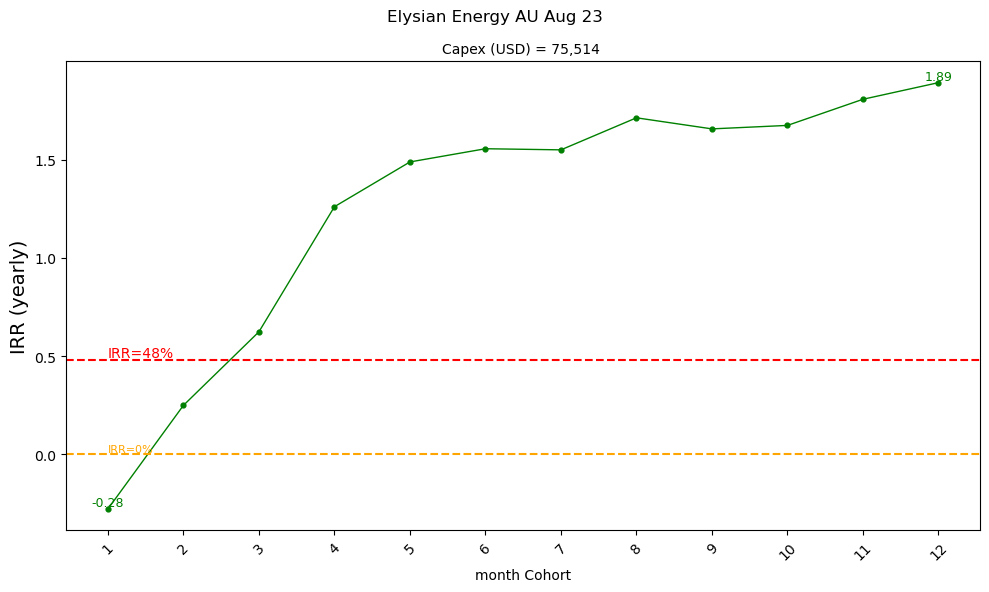

In [68]:

plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'], df_cf['irr_yearly'], color='green',s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'], df_cf['irr_yearly'], color='green', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('month Cohort')
plt.ylabel('IRR (yearly)',fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0,3]),0), fontsize=10)

# Rotate x-axis labels for better readability (optional)

#x_labels = df_cf['month_cohort'].dt.strftime('%Y-%m-%d')  # Format as string
#short_x_labels = x_labels.str.slice(0, 7)  # Get the first 6 letters

plt.xticks(df_cf['month_cohort'], rotation=45)


# Annotate each point with its y-value 
#for i, value in enumerate(df_cf['irr_yearly']):
#    plt.text(df_cf['month_cohort'][i], df_cf['irr_yearly'][i], 
#             f'{value:,.2f}', ha='center', va='bottom', fontsize=9)


#plt.axhline(y=df_average, color='red', linestyle='--', label=f'Average: {df_average:,.2f}')

#plt.text(df_cf['month_cohort'].min(), df_average, f'Avg: {df_average:,.2f}', 
 #        color='red', va='bottom', ha='right', fontsize=10)

# Get the last value for annotation
last_x = df_cf['month_cohort'].iloc[-1]
last_y = df_cf['irr_yearly'].iloc[-1]
# Add a label for the last point
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['irr_yearly'].iloc[0]
# Add a label for the last point
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Add a line where y = 0
plt.axhline(y=0, color='orange', linestyle='--', label='y = 0')
# Add a label for the y = 0 line
plt.text(df_cf['month_cohort'].min(), 0, 'IRR=0%', color='orange', va='bottom', ha='left', fontsize=8)


# Add a line where y = 3.32% (48% yearly)
plt.axhline(y=48*1E-2, color='red', linestyle='--', label='y = 3.32%')
# Add a label for the y = 0 line
plt.text(df_cf['month_cohort'].min(), 48*1E-2, 'IRR=48%', color='red', va='bottom', ha='left', fontsize=10)

# Show plot
plt.tight_layout()  
plt.show()


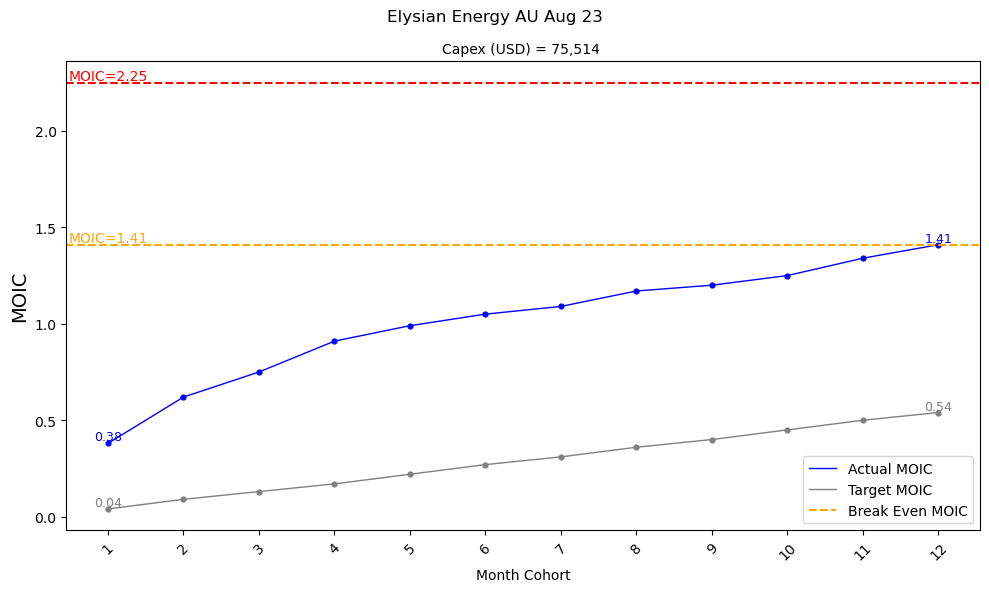

In [69]:

plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'], df_cf['moic'], color='blue', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'], df_cf['moic'], color='blue', linestyle='-', linewidth=1, label='Actual MOIC')

# Add line of moic target
plt.scatter(df_cf['month_cohort'], df_cf['moic_target'], color='gray', s=12)
plt.plot(df_cf['month_cohort'], df_cf['moic_target'], color='gray', linestyle='-', linewidth=1, label='Target MOIC')

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('MOIC', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Get current x-axis ticks
ticks = df_cf['month_cohort']
plt.xticks(ticks, rotation=45)

# Modify specific tick label to be bold or different color
#ax = plt.gca()
#for tick in ax.get_xticklabels():
#    if tick.get_text() == str(first_negative_balance_cohort_month):
#        tick.set_color('orange')  
#        tick.set_weight('bold') 



# Annotate last point with its y-value
last_x = df_cf['month_cohort'].iloc[-1]
last_y = df_cf['moic'].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate first point with its y-value
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['moic'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Get the last value for annotation for target MOIC
last_y_target = df_cf['moic_target'].iloc[-1]
plt.text(last_x, last_y_target, f'{last_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')
# Get the first value for annotation for target MOIC
first_y_target = df_cf['moic_target'].iloc[0]
plt.text(first_x, first_y_target, f'{first_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Add a line where y = 2.25
plt.axhline(y=2.25, color='red', linestyle='--', label='_nolegend_')
plt.text(df_cf['month_cohort'].min(), 2.25, 'MOIC=2.25', color='red', va='bottom', ha='center', fontsize=10)

# Add a line where y = moic_break_even
plt.axhline(y=moic_break_even, color='orange', linestyle='--', label='Break Even MOIC')
plt.text(df_cf['month_cohort'].min(), moic_break_even, f'MOIC={moic_break_even}', color='orange', va='bottom', ha='center', fontsize=10)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()  
plt.show()

In [70]:
book_name

'Elysian Energy AU Aug 23'

In [71]:
df_loan

,cohort_month,monthly_payment,principal_payment,interest_payment,remaining_balance
0,1,33535.11,32599.499478,935.610522,84731.080522
1,2,20834.96,20159.302465,675.657535,64571.778056
2,3,11400.65,10885.745574,514.904426,53686.032482
3,4,13987.73,13559.630038,428.099962,40126.402444
4,5,7058.09,6738.116432,319.973568,33388.286012
5,6,5424.99,5158.747119,266.242881,28229.538894
6,7,3915.42,3690.313693,225.106307,24539.225201
7,8,6915.45,6719.770772,195.679228,17819.454429
8,9,2762.64,2620.545168,142.094832,15198.909261
9,10,4550.54,4429.341763,121.198237,10769.567498


In [72]:
df_cf

,book_id,book_name,month_cohort,calendary_month,calendary_year,actual_amount,actual_amount_usd,target_prediction_amount,target_prediction_amount_usd,moic,moic_target,irr,irr_yearly
0,5010243505,Elysian Energy AU Aug 23,1,10,2023,44713.48,28781.67,5267.10,3390.39,0.38,0.04,-0.0268,-0.278186
1,5010243505,Elysian Energy AU Aug 23,2,11,2023,27779.95,17836.53,4996.08,3207.80,0.62,0.09,0.0187,0.248981
2,5010243505,Elysian Energy AU Aug 23,3,12,2023,15200.87,10134.42,5007.04,3338.19,0.75,0.13,0.0412,0.623342
3,5010243505,Elysian Energy AU Aug 23,4,1,2024,18650.31,12700.85,5043.47,3434.60,0.91,0.17,0.0703,1.259781
4,5010243505,Elysian Energy AU Aug 23,5,2,2024,9410.78,6187.40,4994.52,3283.80,0.99,0.22,0.0789,1.487564
5,5010243505,Elysian Energy AU Aug 23,6,3,2024,7233.32,4726.89,5887.69,3847.53,1.05,0.27,0.0813,1.554785
6,5010243505,Elysian Energy AU Aug 23,7,4,2024,5220.56,3407.75,5307.72,3464.64,1.09,0.31,0.0811,1.549121
7,5010243505,Elysian Energy AU Aug 23,8,5,2024,9220.60,5963.47,5422.51,3507.03,1.17,0.36,0.0867,1.712164
8,5010243505,Elysian Energy AU Aug 23,9,6,2024,3683.52,2454.33,5119.27,3410.97,1.20,0.40,0.0848,1.655805
9,5010243505,Elysian Energy AU Aug 23,10,7,2024,6067.38,4045.46,5592.26,3728.67,1.25,0.45,0.0854,1.673485


## Axactor ES Jul 2023

In [74]:
###Manual:
book_id='4206843141'

In [75]:
###this book didn't achieve break even on moic
### Verification: if df_loan['remaining_balance'].tail(1) is positive -> moic break even is not reached

In [76]:

query_purchase='''SELECT book_id,actual_purchase_price,settlement_date,round(actual_purchase_price_usd,2) actual_purchase_price_usd, Region
FROM presentation.dim_books db
where 1=1
and book_id='{}' '''.format(book_id)
df_purch = pandas_gbq.read_gbq(query_purchase,project_id="data-team-318806")
query_cf='''SELECT book_id,book_name,month_cohort,calendary_month, calendary_year
,round(sum(actual_amount),2) actual_amount,round(sum(actual_amount_usd),2) actual_amount_usd
,round(sum(target_prediction_amount),2)target_prediction_amount  ,round(sum(target_prediction_amount_usd),2) target_prediction_amount_usd
FROM presentation.fact_performance_matrics
where 1=1
and book_id='{}'
group by all
having month_cohort is not null and actual_amount is not null
order by month_cohort'''.format(book_id)
df_cf=pandas_gbq.read_gbq(query_cf,project_id="data-team-318806")
book_name=df_cf.iloc[0,1]
### MOIC Calculation
cashflow=df_cf['actual_amount'].tolist()
#### Calculating Dynamic MOIC
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
    
df_cf['moic']=moic 
#### Calculating Dynamic MOIC based on target
cashflow=[]
cashflow=df_cf['target_prediction_amount'].tolist()

moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)

df_cf['moic_target']=moic 
####Adding Value of P&I
price= purchase_value.copy()
monthly_rate = ((1+annual_interest_rate )**(1/12))-1
monthly_payments = round(df_cf['actual_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []
df_loan=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan = pd.DataFrame(data)

#first_negative_balance = df_loan[df_loan["remaining_balance"] < 0].iloc[0]
#first_negative_balance_cohort_month = int(first_negative_balance["cohort_month"])


### Getting moic_break_even when month_cohort=first_negative_balance_cohort_month
#moic_break_even = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month, 'moic'].values[0]

####Calculting IRR
df_irr_actual=df_cf['actual_amount'].tolist().copy()
df_irr_target=df_cf['target_prediction_amount'].tolist().copy()

num_elements = len(df_irr_actual)  

combined_lists = []
combined_lists_array=[]

for i in range(1, num_elements + 1):
    new_list = df_irr_actual[:i] + df_irr_target[i:]
    combined_lists.append(new_list)

combined_lists_array = np.array(combined_lists)

###Adding purchase as negative number

fixed_value=0
fixed_value = df_purch.iloc[0, 1] * -1

extended_lists = []
extended_lists_array=[]
for lst in combined_lists_array:
    new_list = [fixed_value] + lst.tolist()
    extended_lists.append(new_list)

extended_lists_array = np.array(extended_lists)

#####value of IRR

irr_temp=0
irr=[]
for list in extended_lists_array:
	irr_temp=round(npf.irr(list),4)
	irr.append(irr_temp)

df_cf['irr']=irr

### IRR yearly basis
irr_yearly = [(1 + rate)**12 - 1 for rate in irr]

df_cf['irr_yearly']=irr_yearly 

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


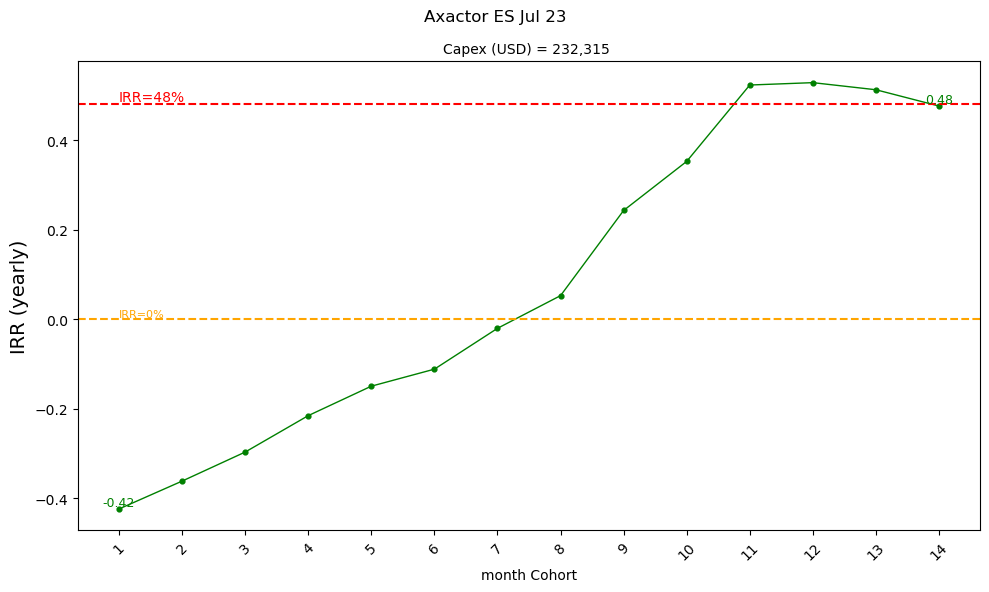

In [77]:

plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'], df_cf['irr_yearly'], color='green',s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'], df_cf['irr_yearly'], color='green', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('month Cohort')
plt.ylabel('IRR (yearly)',fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0,3]),0), fontsize=10)

# Rotate x-axis labels for better readability (optional)

#x_labels = df_cf['month_cohort'].dt.strftime('%Y-%m-%d')  # Format as string
#short_x_labels = x_labels.str.slice(0, 7)  # Get the first 6 letters

plt.xticks(df_cf['month_cohort'], rotation=45)


# Annotate each point with its y-value 
#for i, value in enumerate(df_cf['irr_yearly']):
#    plt.text(df_cf['month_cohort'][i], df_cf['irr_yearly'][i], 
#             f'{value:,.2f}', ha='center', va='bottom', fontsize=9)


#plt.axhline(y=df_average, color='red', linestyle='--', label=f'Average: {df_average:,.2f}')

#plt.text(df_cf['month_cohort'].min(), df_average, f'Avg: {df_average:,.2f}', 
 #        color='red', va='bottom', ha='right', fontsize=10)

# Get the last value for annotation
last_x = df_cf['month_cohort'].iloc[-1]
last_y = df_cf['irr_yearly'].iloc[-1]
# Add a label for the last point
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Get the 1st value for annotation
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['irr_yearly'].iloc[0]
# Add a label for the last point
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Add a line where y = 0
plt.axhline(y=0, color='orange', linestyle='--', label='y = 0')
# Add a label for the y = 0 line
plt.text(df_cf['month_cohort'].min(), 0, 'IRR=0%', color='orange', va='bottom', ha='left', fontsize=8)


# Add a line where y = 3.32% (48% yearly)
plt.axhline(y=48*1E-2, color='red', linestyle='--', label='y = 3.32%')
# Add a label for the y = 0 line
plt.text(df_cf['month_cohort'].min(), 48*1E-2, 'IRR=48%', color='red', va='bottom', ha='left', fontsize=10)

# Show plot
plt.tight_layout()  
plt.show()

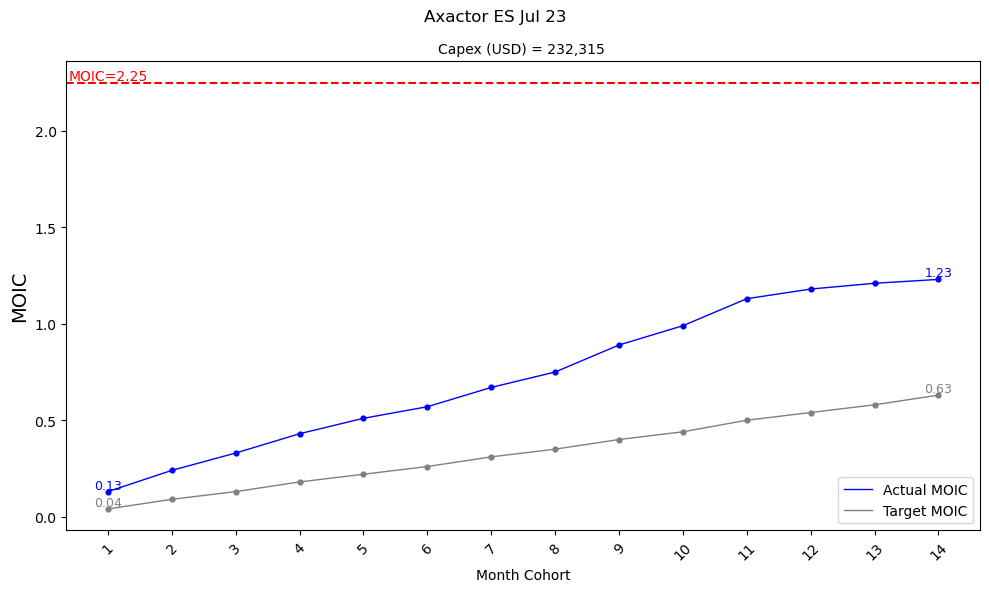

In [78]:

plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'], df_cf['moic'], color='blue', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'], df_cf['moic'], color='blue', linestyle='-', linewidth=1, label='Actual MOIC')

# Add line of moic target
plt.scatter(df_cf['month_cohort'], df_cf['moic_target'], color='gray', s=12)
plt.plot(df_cf['month_cohort'], df_cf['moic_target'], color='gray', linestyle='-', linewidth=1, label='Target MOIC')

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('MOIC', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Get current x-axis ticks
ticks = df_cf['month_cohort']
plt.xticks(ticks, rotation=45)

# Modify specific tick label to be bold or different color
#ax = plt.gca()
#for tick in ax.get_xticklabels():
#    if tick.get_text() == str(first_negative_balance_cohort_month):
#        tick.set_color('orange')  
#        tick.set_weight('bold') 



# Annotate last point with its y-value
last_x = df_cf['month_cohort'].iloc[-1]
last_y = df_cf['moic'].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate first point with its y-value
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['moic'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Get the last value for annotation for target MOIC
last_y_target = df_cf['moic_target'].iloc[-1]
plt.text(last_x, last_y_target, f'{last_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Get the first value for annotation for target MOIC
first_y_target = df_cf['moic_target'].iloc[0]
plt.text(first_x, first_y_target, f'{first_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Add a line where y = 2.25
plt.axhline(y=2.25, color='red', linestyle='--', label='_nolegend_')
plt.text(df_cf['month_cohort'].min(), 2.25, 'MOIC=2.25', color='red', va='bottom', ha='center', fontsize=10)

# Add a line where y = moic_break_even
#plt.axhline(y=moic_break_even, color='orange', linestyle='--', label='Break Even MOIC')
#plt.text(df_cf['month_cohort'].min(), moic_break_even, f'MOIC={moic_break_even}', color='orange', va='bottom', ha='center', fontsize=10)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()  
plt.show()

In [79]:
book_name

'Axactor ES Jul 23'

In [80]:
df_loan

,cohort_month,monthly_payment,principal_payment,interest_payment,remaining_balance
0,1,20958.55,19284.010413,1674.539587,190712.239587
1,2,16149.06,14628.293820,1520.766180,176083.945767
2,3,15083.47,13679.351889,1404.118111,162404.593878
3,4,15565.00,14269.962962,1295.037038,148134.630916
4,5,12866.33,11685.083651,1181.246349,136449.547265
5,6,9631.94,8543.872149,1088.067851,127905.675116
6,7,14978.74,13958.802185,1019.937815,113946.872931
7,8,13068.98,12160.351634,908.628366,101786.521298
8,9,21799.34,20987.679985,811.660015,80798.841312
9,10,15852.52,15208.218693,644.301307,65590.622619


In [81]:
df_cf

,book_id,book_name,month_cohort,calendary_month,calendary_year,actual_amount,actual_amount_usd,target_prediction_amount,target_prediction_amount_usd,moic,moic_target,irr,irr_yearly
0,4206843141,Axactor ES Jul 23,1,8,2023,27944.73,30760.55,8628.03,9497.42,0.13,0.04,-0.0449,-0.423783
1,4206843141,Axactor ES Jul 23,2,9,2023,21532.08,23245.15,9407.70,10156.17,0.24,0.09,-0.0367,-0.361533
2,4206843141,Axactor ES Jul 23,3,10,2023,20111.30,21244.71,9489.36,10024.15,0.33,0.13,-0.0289,-0.296657
3,4206843141,Axactor ES Jul 23,4,11,2023,20753.34,21967.13,9427.91,9979.32,0.43,0.18,-0.0200,-0.215283
4,4206843141,Axactor ES Jul 23,5,12,2023,17155.11,18686.47,8937.13,9734.90,0.51,0.22,-0.0134,-0.149463
5,4206843141,Axactor ES Jul 23,6,1,2024,12842.58,14175.24,8443.09,9319.21,0.57,0.26,-0.0098,-0.111464
6,4206843141,Axactor ES Jul 23,7,2,2024,19971.65,21717.88,9922.32,10789.88,0.67,0.31,-0.0017,-0.020210
7,4206843141,Axactor ES Jul 23,8,3,2024,17425.31,18907.59,9659.46,10481.14,0.75,0.35,0.0043,0.052838
8,4206843141,Axactor ES Jul 23,9,4,2024,29065.79,31365.00,9517.77,10270.66,0.89,0.40,0.0183,0.243108
9,4206843141,Axactor ES Jul 23,10,5,2024,21136.69,22523.58,9969.06,10623.18,0.99,0.44,0.0255,0.352782


## Dineo ES Aug 2022

In [83]:
###Manual:
book_id='3526243721'

In [84]:
###this book didn't achieve break even on moic.
### Verification: if df_loan['remaining_balance'].tail(1) is positive -> moic break even is not reached

In [85]:
query_purchase='''SELECT book_id,actual_purchase_price,settlement_date,round(actual_purchase_price_usd,2) actual_purchase_price_usd, Region
FROM presentation.dim_books db
where 1=1
and book_id='{}' '''.format(book_id)
df_purch = pandas_gbq.read_gbq(query_purchase,project_id="data-team-318806")
query_cf='''SELECT book_id,book_name,month_cohort,calendary_month, calendary_year
,round(sum(actual_amount),2) actual_amount,round(sum(actual_amount_usd),2) actual_amount_usd
,round(sum(target_prediction_amount),2)target_prediction_amount  ,round(sum(target_prediction_amount_usd),2) target_prediction_amount_usd
FROM presentation.fact_performance_matrics
where 1=1
and book_id='{}'
group by all
having month_cohort is not null and actual_amount is not null
order by month_cohort'''.format(book_id)
df_cf=pandas_gbq.read_gbq(query_cf,project_id="data-team-318806")
book_name=df_cf.iloc[0,1]
### MOIC Calculation
cashflow=df_cf['actual_amount'].tolist()
#### Calculating Dynamic MOIC
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
    
df_cf['moic']=moic 
#### Calculating Dynamic MOIC based on target
cashflow=[]
cashflow=df_cf['target_prediction_amount'].tolist()

moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)

df_cf['moic_target']=moic 
####Adding Value of P&I
price= purchase_value.copy()
monthly_rate = ((1+annual_interest_rate )**(1/12))-1
monthly_payments = round(df_cf['actual_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []
df_loan=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan = pd.DataFrame(data)

#first_negative_balance = df_loan[df_loan["remaining_balance"] < 0].iloc[0]
#first_negative_balance_cohort_month = int(first_negative_balance["cohort_month"])


### Getting moic_break_even when month_cohort=first_negative_balance_cohort_month
#moic_break_even = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month, 'moic'].values[0]

####Calculting IRR
df_irr_actual=df_cf['actual_amount'].tolist().copy()
df_irr_target=df_cf['target_prediction_amount'].tolist().copy()

num_elements = len(df_irr_actual)  

combined_lists = []
combined_lists_array=[]

for i in range(1, num_elements + 1):
    new_list = df_irr_actual[:i] + df_irr_target[i:]
    combined_lists.append(new_list)

combined_lists_array = np.array(combined_lists)

###Adding purchase as negative number

fixed_value=0
fixed_value = df_purch.iloc[0, 1] * -1

extended_lists = []
extended_lists_array=[]
for lst in combined_lists_array:
    new_list = [fixed_value] + lst.tolist()
    extended_lists.append(new_list)

extended_lists_array = np.array(extended_lists)

#####value of IRR

irr_temp=0
irr=[]
for list in extended_lists_array:
	irr_temp=round(npf.irr(list),4)
	irr.append(irr_temp)

df_cf['irr']=irr

### IRR yearly basis
irr_yearly = [(1 + rate)**12 - 1 for rate in irr]

df_cf['irr_yearly']=irr_yearly 

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


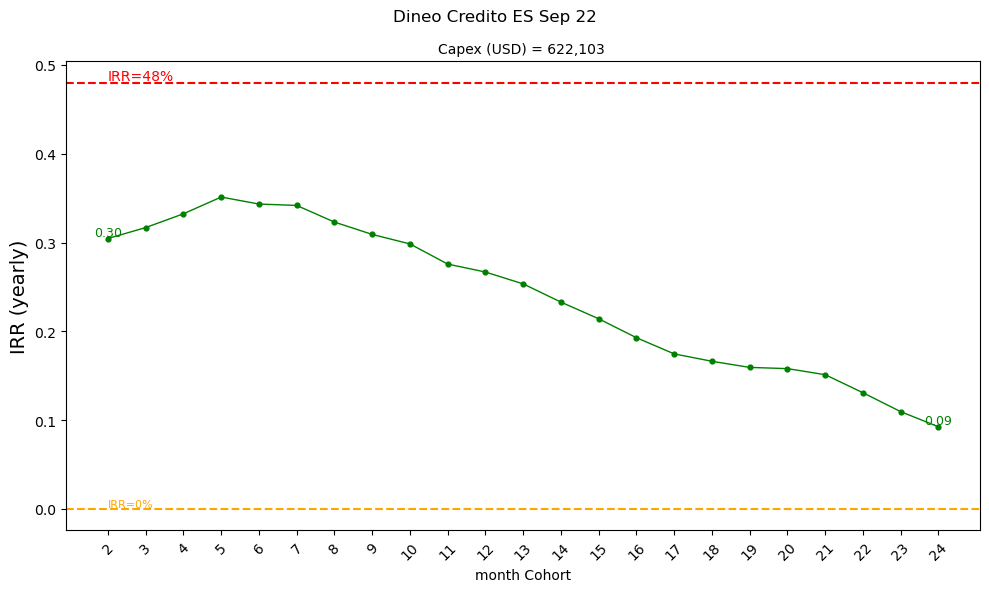

In [86]:

plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'], df_cf['irr_yearly'], color='green',s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'], df_cf['irr_yearly'], color='green', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('month Cohort')
plt.ylabel('IRR (yearly)',fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0,3]),0), fontsize=10)

# Rotate x-axis labels for better readability (optional)

#x_labels = df_cf['month_cohort'].dt.strftime('%Y-%m-%d')  # Format as string
#short_x_labels = x_labels.str.slice(0, 7)  # Get the first 6 letters

plt.xticks(df_cf['month_cohort'], rotation=45)


# Annotate each point with its y-value 
#for i, value in enumerate(df_cf['irr_yearly']):
#    plt.text(df_cf['month_cohort'][i], df_cf['irr_yearly'][i], 
#             f'{value:,.2f}', ha='center', va='bottom', fontsize=9)


#plt.axhline(y=df_average, color='red', linestyle='--', label=f'Average: {df_average:,.2f}')

#plt.text(df_cf['month_cohort'].min(), df_average, f'Avg: {df_average:,.2f}', 
 #        color='red', va='bottom', ha='right', fontsize=10)

# Get the last value for annotation
last_x = df_cf['month_cohort'].iloc[-1]
last_y = df_cf['irr_yearly'].iloc[-1]
# Add a label for the last point
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Get the 1st value for annotation
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['irr_yearly'].iloc[0]
# Add a label for the last point
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Add a line where y = 0
plt.axhline(y=0, color='orange', linestyle='--', label='y = 0')
# Add a label for the y = 0 line
plt.text(df_cf['month_cohort'].min(), 0, 'IRR=0%', color='orange', va='bottom', ha='left', fontsize=8)


# Add a line where y = 3.32% (48% yearly)
plt.axhline(y=48*1E-2, color='red', linestyle='--', label='y = 3.32%')
# Add a label for the y = 0 line
plt.text(df_cf['month_cohort'].min(), 48*1E-2, 'IRR=48%', color='red', va='bottom', ha='left', fontsize=10)

# Show plot
plt.tight_layout()  
plt.show()

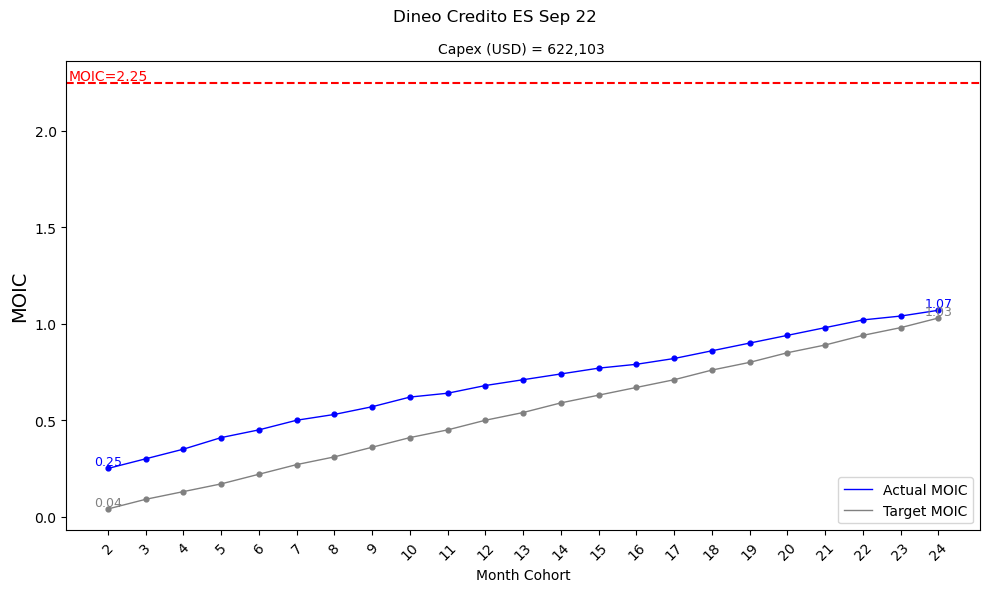

In [87]:

plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'], df_cf['moic'], color='blue', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'], df_cf['moic'], color='blue', linestyle='-', linewidth=1, label='Actual MOIC')

# Add line of moic target
plt.scatter(df_cf['month_cohort'], df_cf['moic_target'], color='gray', s=12)
plt.plot(df_cf['month_cohort'], df_cf['moic_target'], color='gray', linestyle='-', linewidth=1, label='Target MOIC')

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('MOIC', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Get current x-axis ticks
ticks = df_cf['month_cohort']
plt.xticks(ticks, rotation=45)

# Modify specific tick label to be bold or different color
#ax = plt.gca()
#for tick in ax.get_xticklabels():
#    if tick.get_text() == str(first_negative_balance_cohort_month):
#        tick.set_color('orange')  
#        tick.set_weight('bold') 



# Annotate last point with its y-value
last_x = df_cf['month_cohort'].iloc[-1]
last_y = df_cf['moic'].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate first point with its y-value
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['moic'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Get the last value for annotation for target MOIC
last_y_target = df_cf['moic_target'].iloc[-1]
plt.text(last_x, last_y_target, f'{last_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Get the first value for annotation for target MOIC
first_y_target = df_cf['moic_target'].iloc[0]
plt.text(first_x, first_y_target, f'{first_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Add a line where y = 2.25
plt.axhline(y=2.25, color='red', linestyle='--', label='_nolegend_')
plt.text(df_cf['month_cohort'].min(), 2.25, 'MOIC=2.25', color='red', va='bottom', ha='center', fontsize=10)

# Add a line where y = moic_break_even
#plt.axhline(y=moic_break_even, color='orange', linestyle='--', label='Break Even MOIC')
#plt.text(df_cf['month_cohort'].min(), moic_break_even, f'MOIC={moic_break_even}', color='orange', va='bottom', ha='center', fontsize=10)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()  
plt.show()

In [88]:
book_name

'Dineo Credito ES Sep 22'

In [89]:
df_loan

,cohort_month,monthly_payment,principal_payment,interest_payment,remaining_balance
0,1,118760.82,113790.410684,4970.409316,509525.589316
1,2,23268.63,19205.601399,4063.028601,490319.987917
2,3,22937.12,19027.239561,3909.880439,471292.748356
3,4,27517.87,23759.715441,3758.154559,447533.032914
4,5,19325.80,15757.108749,3568.691251,431775.924165
5,6,20490.23,17047.188147,3443.041853,414728.736018
6,7,16864.17,13557.064819,3307.105181,401171.671199
7,8,19327.32,16128.320758,3198.999242,385043.350441
8,9,19546.72,16476.330252,3070.389748,368567.020189
9,10,11243.97,8304.964824,2939.005176,360262.055366


In [90]:
df_cf

,book_id,book_name,month_cohort,calendary_month,calendary_year,actual_amount,actual_amount_usd,target_prediction_amount,target_prediction_amount_usd,moic,moic_target,irr,irr_yearly
0,3526243721,Dineo Credito ES Sep 22,2,11,2022,158347.76,156429.16,27984.15,27645.08,0.25,0.04,0.0224,0.304518
1,3526243721,Dineo Credito ES Sep 22,3,12,2022,31024.84,32662.88,26527.40,27927.99,0.30,0.09,0.0232,0.316820
2,3526243721,Dineo Credito ES Sep 22,4,1,2023,30582.83,32737.44,25060.98,26826.57,0.35,0.13,0.0242,0.332347
3,3526243721,Dineo Credito ES Sep 22,5,2,2023,36690.49,40405.36,29451.68,32433.63,0.41,0.17,0.0254,0.351200
4,3526243721,Dineo Credito ES Sep 22,6,3,2023,25767.73,27491.74,28671.45,30589.74,0.45,0.22,0.0249,0.343315
5,3526243721,Dineo Credito ES Sep 22,7,4,2023,27320.31,29699.09,28250.87,30710.68,0.50,0.27,0.0248,0.341743
6,3526243721,Dineo Credito ES Sep 22,8,5,2023,22485.56,24663.31,29590.41,32456.26,0.53,0.31,0.0236,0.323011
7,3526243721,Dineo Credito ES Sep 22,9,6,2023,25769.76,27729.40,31408.27,33796.69,0.57,0.36,0.0227,0.309119
8,3526243721,Dineo Credito ES Sep 22,10,7,2023,26062.29,28450.73,30702.35,33516.02,0.62,0.41,0.0220,0.298407
9,3526243721,Dineo Credito ES Sep 22,11,8,2023,14991.96,16502.61,25609.93,28190.48,0.64,0.45,0.0205,0.275722


## Sumo Energy AU Jul 2024 (Pre DCA)

In [92]:
###Manual:
book_id='6977655973'

In [93]:
###this book didn't achieve break even on moic
### Verification: if df_loan['remaining_balance'].tail(1) is positive -> moic break even is not reached

In [94]:


query_purchase='''SELECT book_id,actual_purchase_price,settlement_date,round(actual_purchase_price_usd,2) actual_purchase_price_usd, Region
FROM presentation.dim_books db
where 1=1
and book_id='{}' '''.format(book_id)
df_purch = pandas_gbq.read_gbq(query_purchase,project_id="data-team-318806")
query_cf='''SELECT book_id,book_name,month_cohort,calendary_month, calendary_year
,round(sum(actual_amount),2) actual_amount,round(sum(actual_amount_usd),2) actual_amount_usd
,round(sum(target_prediction_amount),2)target_prediction_amount  ,round(sum(target_prediction_amount_usd),2) target_prediction_amount_usd
FROM presentation.fact_performance_matrics
where 1=1
and book_id='{}'
group by all
having month_cohort is not null and actual_amount is not null
order by month_cohort'''.format(book_id)
df_cf=pandas_gbq.read_gbq(query_cf,project_id="data-team-318806")
book_name=df_cf.iloc[0,1]
### MOIC Calculation
cashflow=df_cf['actual_amount'].tolist()
#### Calculating Dynamic MOIC
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
    
df_cf['moic']=moic 
#### Calculating Dynamic MOIC based on target
cashflow=[]
cashflow=df_cf['target_prediction_amount'].tolist()

moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)

df_cf['moic_target']=moic 
####Adding Value of P&I
price= purchase_value.copy()
monthly_rate = ((1+annual_interest_rate )**(1/12))-1
monthly_payments = round(df_cf['actual_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []
df_loan=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan = pd.DataFrame(data)

#first_negative_balance = df_loan[df_loan["remaining_balance"] < 0].iloc[0]
#first_negative_balance_cohort_month = int(first_negative_balance["cohort_month"])


### Getting moic_break_even when month_cohort=first_negative_balance_cohort_month
#moic_break_even = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month, 'moic'].values[0]

####Calculting IRR
df_irr_actual=df_cf['actual_amount'].tolist().copy()
df_irr_target=df_cf['target_prediction_amount'].tolist().copy()

num_elements = len(df_irr_actual)  

combined_lists = []
combined_lists_array=[]

for i in range(1, num_elements + 1):
    new_list = df_irr_actual[:i] + df_irr_target[i:]
    combined_lists.append(new_list)

combined_lists_array = np.array(combined_lists)

###Adding purchase as negative number

fixed_value=0
fixed_value = df_purch.iloc[0, 1] * -1

extended_lists = []
extended_lists_array=[]
for lst in combined_lists_array:
    new_list = [fixed_value] + lst.tolist()
    extended_lists.append(new_list)

extended_lists_array = np.array(extended_lists)

#####value of IRR

irr_temp=0
irr=[]
for list in extended_lists_array:
	irr_temp=round(npf.irr(list),4)
	irr.append(irr_temp)

df_cf['irr']=irr

### IRR yearly basis
irr_yearly = [(1 + rate)**12 - 1 for rate in irr]

df_cf['irr_yearly']=irr_yearly 

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


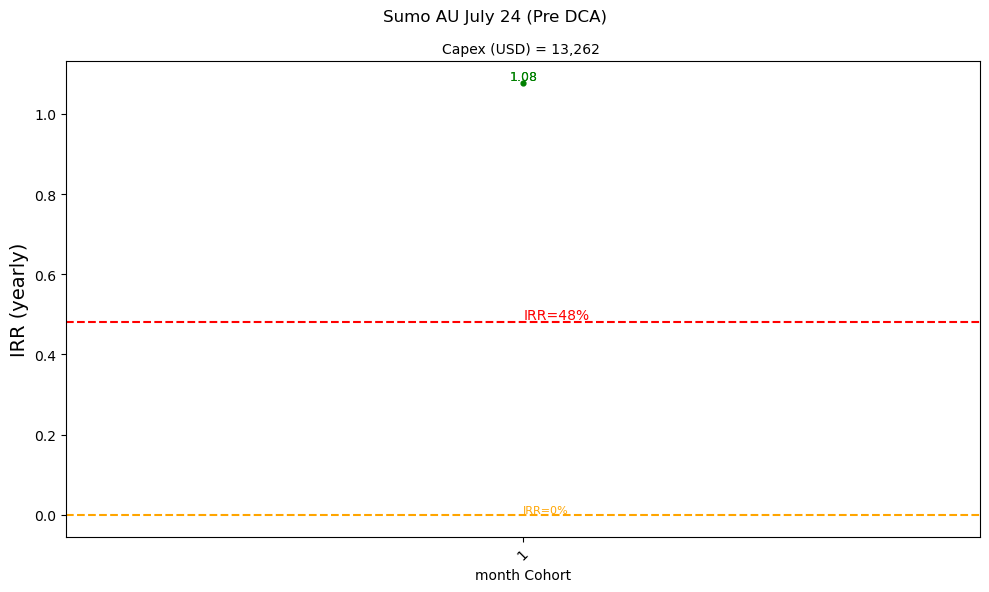

In [95]:

plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'], df_cf['irr_yearly'], color='green',s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'], df_cf['irr_yearly'], color='green', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('month Cohort')
plt.ylabel('IRR (yearly)',fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0,3]),0), fontsize=10)

# Rotate x-axis labels for better readability (optional)

#x_labels = df_cf['month_cohort'].dt.strftime('%Y-%m-%d')  # Format as string
#short_x_labels = x_labels.str.slice(0, 7)  # Get the first 6 letters

plt.xticks(df_cf['month_cohort'], rotation=45)


# Annotate each point with its y-value 
#for i, value in enumerate(df_cf['irr_yearly']):
#    plt.text(df_cf['month_cohort'][i], df_cf['irr_yearly'][i], 
#             f'{value:,.2f}', ha='center', va='bottom', fontsize=9)


#plt.axhline(y=df_average, color='red', linestyle='--', label=f'Average: {df_average:,.2f}')

#plt.text(df_cf['month_cohort'].min(), df_average, f'Avg: {df_average:,.2f}', 
 #        color='red', va='bottom', ha='right', fontsize=10)

# Get the last value for annotation
last_x = df_cf['month_cohort'].iloc[-1]
last_y = df_cf['irr_yearly'].iloc[-1]
# Add a label for the last point
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Get the 1st value for annotation
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['irr_yearly'].iloc[0]
# Add a label for the last point
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Add a line where y = 0
plt.axhline(y=0, color='orange', linestyle='--', label='y = 0')
# Add a label for the y = 0 line
plt.text(df_cf['month_cohort'].min(), 0, 'IRR=0%', color='orange', va='bottom', ha='left', fontsize=8)


# Add a line where y = 3.32% (48% yearly)
plt.axhline(y=48*1E-2, color='red', linestyle='--', label='y = 3.32%')
# Add a label for the y = 0 line
plt.text(df_cf['month_cohort'].min(), 48*1E-2, 'IRR=48%', color='red', va='bottom', ha='left', fontsize=10)

# Show plot
plt.tight_layout()  
plt.show()

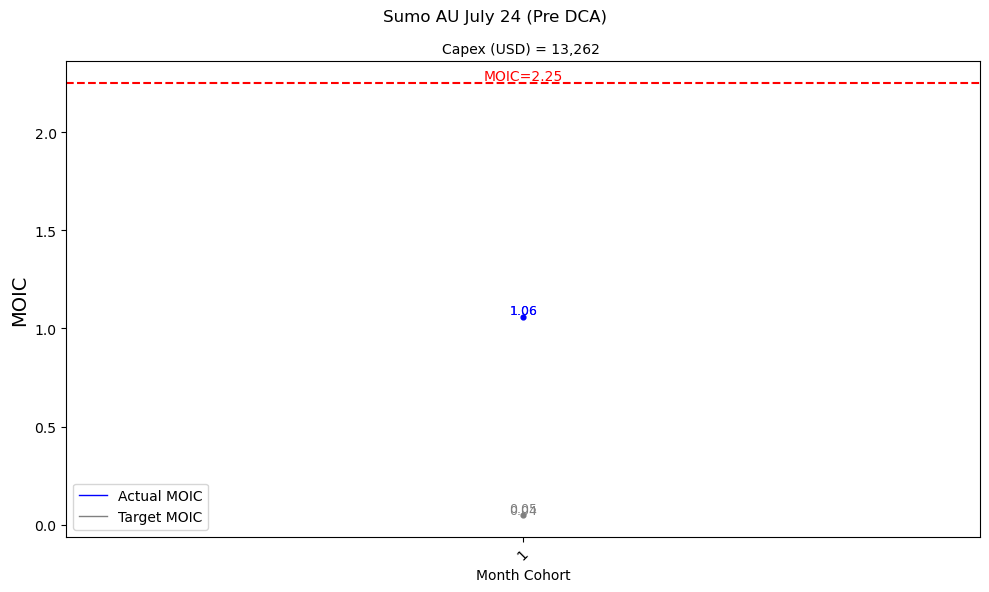

In [96]:

plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'], df_cf['moic'], color='blue', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'], df_cf['moic'], color='blue', linestyle='-', linewidth=1, label='Actual MOIC')

# Add line of moic target
plt.scatter(df_cf['month_cohort'], df_cf['moic_target'], color='gray', s=12)
plt.plot(df_cf['month_cohort'], df_cf['moic_target'], color='gray', linestyle='-', linewidth=1, label='Target MOIC')

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('MOIC', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Get current x-axis ticks
ticks = df_cf['month_cohort']
plt.xticks(ticks, rotation=45)

# Modify specific tick label to be bold or different color
#ax = plt.gca()
#for tick in ax.get_xticklabels():
#    if tick.get_text() == str(first_negative_balance_cohort_month):
#        tick.set_color('orange')  
#        tick.set_weight('bold') 



# Annotate last point with its y-value
last_x = df_cf['month_cohort'].iloc[-1]
last_y = df_cf['moic'].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')


# Annotate first point with its y-value
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['moic'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Get the last value for annotation for target MOIC
last_y_target = df_cf['moic_target'].iloc[-1]
plt.text(last_x, last_y_target, f'{last_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

plt.text(first_x, first_y_target, f'{first_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Add a line where y = 2.25
plt.axhline(y=2.25, color='red', linestyle='--', label='_nolegend_')
plt.text(df_cf['month_cohort'].min(), 2.25, 'MOIC=2.25', color='red', va='bottom', ha='center', fontsize=10)

# Add a line where y = moic_break_even
#plt.axhline(y=moic_break_even, color='orange', linestyle='--', label='Break Even MOIC')
#plt.text(df_cf['month_cohort'].min(), moic_break_even, f'MOIC={moic_break_even}', color='orange', va='bottom', ha='center', fontsize=10)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()  
plt.show()

In [97]:
book_name

'Sumo AU July 24 (Pre DCA)'

In [98]:
df_loan

,cohort_month,monthly_payment,principal_payment,interest_payment,remaining_balance
0,1,16236.4,16073.967956,162.432044,4295.882044


In [99]:
df_cf

,book_id,book_name,month_cohort,calendary_month,calendary_year,actual_amount,actual_amount_usd,target_prediction_amount,target_prediction_amount_usd,moic,moic_target,irr,irr_yearly
0,6977655973,Sumo AU July 24 (Pre DCA),1,9,2024,21648.53,14647.4,979.74,662.89,1.06,0.05,0.0628,1.076914
